**Description:**

Another research question focuses on **heterogeneity** within each chamber. Under antibiotic exposure, some cells may continue growing rapidly while others slow down or stop. When growth is measured only at the population-averaged level, this variability can be hidden, allowing a small resistant subpopulation to remain undetected.

The data folders used in this analysis were uploaded to **Google Drive**.

<ins>Approach:</ins> Each chamber is divided into 3 horizontal patches, and the area of each region is measured over time. Growth rates are then computed for every patch, and the patch with the highest average growth is labeled as the hotspot.

In this dataset, heterogeneity is not strongly present, and the growth curves shown in the `Actual Analysis` section display only slight variation. However, the visual examination in the `Further Inspection` section shows that the algorithm tends to identify a reasonable hotspot, finding regions that appear to grow faster than the other patches.


In [13]:
import os
from google.colab import drive
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
import pickle
from pathlib import Path
from PIL import Image
from scipy.stats import linregress
from scipy import ndimage
from tqdm import tqdm

drive.mount('/content/drive')

Mounted at /content/drive


# Functions provided from `EXP-23-BZ3167.ipynb`

## Exponential Growth

In [6]:
def exp_growth_fit(x, a, b):
    """
    Exponential growth model: Area = a * exp(b * x)
    """
    return a * np.exp(b * x)


## Area Calculation

In [7]:
def calculate_area_from_mask(mask):
    """
    Calculate total bacterial area from segmentation mask.

    Args:
        mask: Segmentation mask where:
              0 = background
              1,2,3,... = individual bacteria

    Returns:
        total_area: Total bacterial area in pixels
    """

    unique_vals, counts = np.unique(mask, return_counts=True)

    # If no bacteria (only zeros), return 0 explicitly
    if len(unique_vals) == 1 and unique_vals[0] == 0:
        return 0

    # Otherwise skip background count (index 0)
    npoints = counts[1:]

    total_area = int(np.sum(npoints))

    return total_area


## Growth Rate Calculation

In [8]:
def calculate_growth_rate_rolling(rolling_number, interval_time, area_data):
    growth_rate_rollings = []

    for i in range(rolling_number, len(area_data)):
        time_rolling = [time for time in range(i-rolling_number, i)]
        area_rolling = [value for value in area_data[i-rolling_number:i]]

        p0 = [1, 0.0005]
        popt, _ = curve_fit(exp_growth_fit, time_rolling, area_rolling, p0=p0)

        growth_rate_h = popt[1] / interval_time * 60
        growth_rate_rollings.append(growth_rate_h)

    return growth_rate_rollings


In [9]:
def fit_exponential(data, rolling_number, divisor):
    """Apply exponential smoothing"""
    fitted_chunk = int(rolling_number / divisor)

    def exponential(x, a, b):
        return a * np.exp(b * x)

    def is_good_fit(x, y, a, b, threshold=0.05):
        if y == 0 or np.isnan(y):
            return True
        fitted_value = exponential(x, a, b)
        if fitted_value == 0:
            return True
        return abs((y - fitted_value) / y) <= threshold

    result = []

    for i in range(0, len(data)-1, fitted_chunk):
        chunk = list(data[i:i+fitted_chunk])

        # Check if chunk has valid data
        if all(np.isnan(chunk)) or max(chunk) < 0.1:
            result.extend(chunk)
            continue

        try:
            popt, _ = curve_fit(exponential, range(len(chunk)), chunk, maxfev=5000)
        except:
            result.extend(chunk)
            continue

        for j, value in enumerate(chunk):
            if not is_good_fit(j, value, *popt):
                chunk[j] = exponential(j, *popt)

        result.extend(chunk)

    return np.array(result)

## Statistics

In [10]:
def find_means_std_sem(data):
    """
    Calculate mean, standard deviation, and standard error of mean

    Args:
        data: List of arrays (one per chamber)

    Returns:
        means: Mean across chambers
        std: Standard deviation (with ddof=1)
        sem: Standard error of mean
    """
    stacked_data = np.vstack(data)
    stacked_data_means = np.mean(stacked_data, axis=0)
    stacked_data_std_dev = np.std(stacked_data, axis=0, ddof=1)
    stacked_data_std_err = stats.sem(stacked_data, axis=0, ddof=1)

    return stacked_data_means, stacked_data_std_dev, stacked_data_std_err


## Normalization

In [11]:
def normalize_lists(list_a, list_b):
    """
    Normalize list_a by list_b, value-by-value.
    list_a / list_b (REF normalizes to 1)
    """
    return np.array([a/b if b != 0 else 0 for a, b in zip(list_a, list_b)])

# Helper functions

## Load chamber

In [2]:
from skimage.transform import resize

def load_chamber(mask_dir, position):
    """
    Load instance masks from PreprocessedPhaseMasks for one position.
    Ensures all frames have the same shape.
    """
    pos_folder = f"Pos{position}"
    mask_path = os.path.join(mask_dir, pos_folder, "PreprocessedPhaseMasks")

    if not os.path.exists(mask_path):
        raise ValueError(f"Path not found: {mask_path}")
    # Collect mask files in chronological order based on frame index
    mask_files = sorted(
        [f for f in os.listdir(mask_path) if f.startswith("MASK_")],
        key=lambda f: int(f.split("_")[-1].split(".")[0])
    )

    masks = []
    target_shape = None

    for mf in tqdm(mask_files, desc=f"Loading Pos{position}"):
        m = np.array(Image.open(os.path.join(mask_path, mf)))

        if m.ndim == 3:
            m = m[:, :, 0]

        m = m.astype(np.int32)

        if target_shape is None:
            target_shape = m.shape
        # Resize mask if its shape does not match the reference
        if m.shape != target_shape:
            m = resize(m, target_shape, order=0, preserve_range=True, anti_aliasing=False).astype(np.int32)

        masks.append(m)

    return np.stack(masks)   # Stack into array of shape (T, H, W)


## Split Patches

This function divides a full mask into a **specified number of horizontal patches**. The mask is split into equal-height segments from top to bottom, and each segment is returned as a separate patch.

In [3]:
def split_into_patches(mask, n_patches=3):
    """
    Split the mask horizontally into n_patches equal-height patches.

    Patch 0 = top
    Patch n = bottom
    """
    h, w = mask.shape
    patch_h = h // n_patches # height of each patch

    patches = []
    for i in range(n_patches):
        start = i * patch_h                  # starting row
        end   = (i+1) * patch_h              # ending row
        patches.append(mask[start:end, :])   # full width

    return patches


## Compute areas for patches

In [4]:
def compute_patch_area_curves(masks, pixel_area, n_patches=3):
    """
    Given masks of shape (T, H, W), compute area-vs-time curves for each patch.

    Returns:
        patch_areas: numpy array shape (n_patches, T)
                     patch_areas[p, t] = area of patch p at time t (μm²)
    """
    T = masks.shape[0] # number of frames
    patch_areas = [ [] for _ in range(n_patches) ] # one list per patch

    for t in range(T):
       # Split the mask of frame t into horizontal patches
        patches = split_into_patches(masks[t], n_patches=n_patches)

        if len(patches) != n_patches:
            raise ValueError(f"split_into_patches returned {len(patches)} patches, expected {n_patches}")
        # Compute area for each patch
        for p_idx, patch in enumerate(patches):
            area_pixels = calculate_area_from_mask(patch)
            patch_areas[p_idx].append(area_pixels * pixel_area)

    # convert to array (n_patches, T)
    return np.array(patch_areas)


## Figures

In [5]:
def plot_patch_growth(stacked_patch_growth, interval_time, rolling_number):
    """
    Plot growth rate for patches (each patch = one trace).

    Args:
        stacked_patch_growth: (n_patches, T) array of growth-rate curves
        interval_time: minutes per frame (usually 2)
        rolling_number: rolling window used for growth rate
    """
    n_patches, num_frame = stacked_patch_growth.shape

    # Time axis (same logic as original)
    time_plot_growth = [t*(interval_time/60) - 1
                        for t in range(0, num_frame + rolling_number)]

    plt.figure(facecolor='white')
    plt.axvline(x=0, color='#FF1F5B', linestyle='--', lw=1)

    # Individual patch traces
    plt.plot(time_plot_growth[rolling_number:],
             stacked_patch_growth.T,
             lw=1.5)

    plt.xlabel("Time (hour)")
    plt.ylabel(r"Growth rate ($h^{-1}$)")
    plt.title("Patch growth rates")
    plt.ylim(-2, 1)
    plt.show()


# Step by step analysis on chamber 101

The procedure is applied step by step to **chamber 101**, where the masks from the chamber are first split horizontally into three equal-height patches.

Loading Pos101: 100%|██████████| 121/121 [00:01<00:00, 71.78it/s]


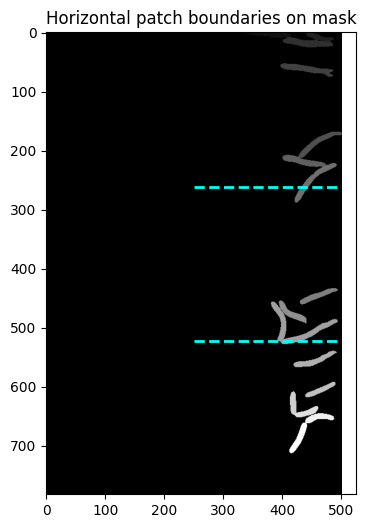

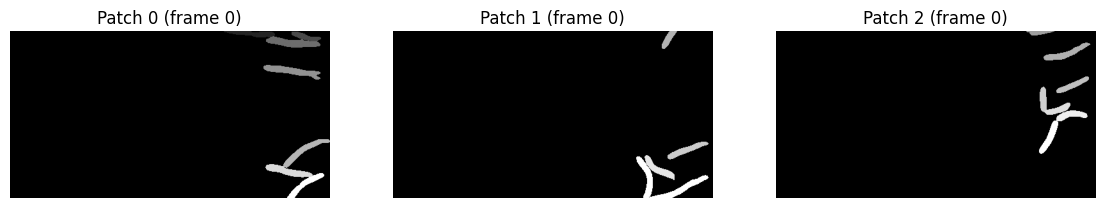

In [15]:
pixel_area = 0.0733**2     # µm² per pixel
rolling_number = 16        # window size for growth-rate fitting
interval_time = 2          # minutes between frames
n_patches = 3              # number of horizontal patches

masks = load_chamber("/content/drive/MyDrive/REF_masks101_110", 101)

# VISUALIZE HORIZONTAL PATCH SPLIT ON FRAME 0
h, w = masks[0].shape
right = masks[0][:, w//2:]
patch_h = right.shape[0] // n_patches

plt.figure(figsize=(8,6))
plt.imshow(masks[0], cmap="gray")
plt.title("Horizontal patch boundaries on mask")

for i in range(1, n_patches):
    y = i * patch_h
    plt.plot([w//2, w], [y, y], color='cyan', linestyle='--', linewidth=2)

plt.show()

# SHOW EACH PATCH FROM FRAME 0
patches_frame0 = split_into_patches(masks[0], n_patches=n_patches)

plt.figure(figsize=(14,4))
for p in range(n_patches):
    plt.subplot(1, n_patches, p+1)
    plt.imshow(patches_frame0[p], cmap='gray')
    plt.title(f"Patch {p} (frame 0)")
    plt.axis("off")
plt.show()

Next, the **area** in each horizontal patch is measured over time, and these area curves are used to compute **patch-specific growth rates** using the rolling exponential fit.

In [16]:
# COMPUTE PATCH AREA CURVES (µm²) OVER TIME
patch_areas = compute_patch_area_curves(masks, pixel_area, n_patches=n_patches)
print("\nPATCH AREA STATS")
for p in range(n_patches):
    arr = np.array(patch_areas[p])
    print(f"Patch {p}: min={arr.min():.2f}, max={arr.max():.2f}, Δ={arr.max()-arr.min():.2f}")

# COMPUTE GROWTH RATES FOR EACH PATCH (h⁻¹)
patch_growth = []

print("\nPATCH GROWTH-RATE SATS")
for p in range(n_patches):
    growth_p = calculate_growth_rate_rolling(
        rolling_number,
        interval_time,
        patch_areas[p]    # this is already in µm²
    )
    patch_growth.append(growth_p)

    print(f"Patch {p} growth min={np.nanmin(growth_p):.3f}, max={np.nanmax(growth_p):.3f}")


PATCH AREA STATS
Patch 0: min=22.56, max=77.70, Δ=55.15
Patch 1: min=7.33, max=17.29, Δ=9.96
Patch 2: min=15.62, max=76.67, Δ=61.05

PATCH GROWTH-RATE SATS
Patch 0 growth min=-0.012, max=0.548
Patch 1 growth min=-1.736, max=0.350
Patch 2 growth min=0.158, max=0.999


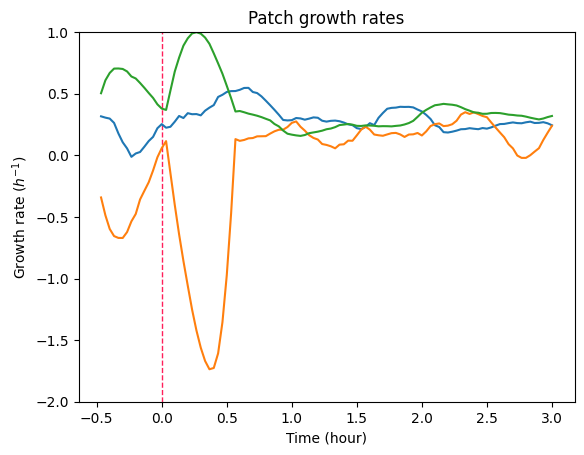

In [17]:
stacked_patch_growth = np.vstack(patch_growth)
plot_patch_growth(stacked_patch_growth, interval_time, rolling_number)

To visualize how each region behaves over time, three representative frames (start, middle, and end of the movie) are displayed with their horizontal patch boundaries, followed by the corresponding extracted patches shown separately.


FRAME 0 (Start (0))


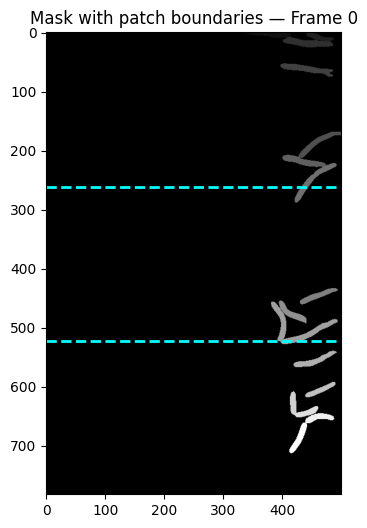

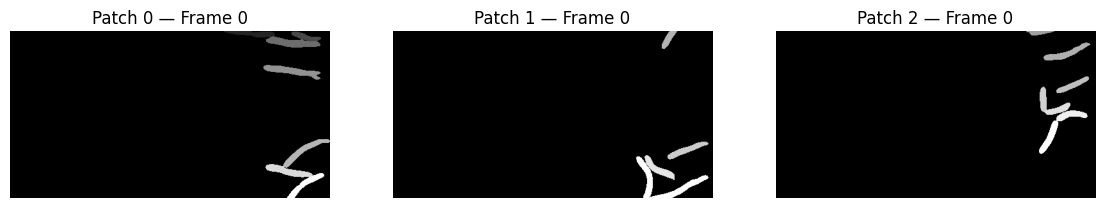


FRAME 60 (Middle (60))


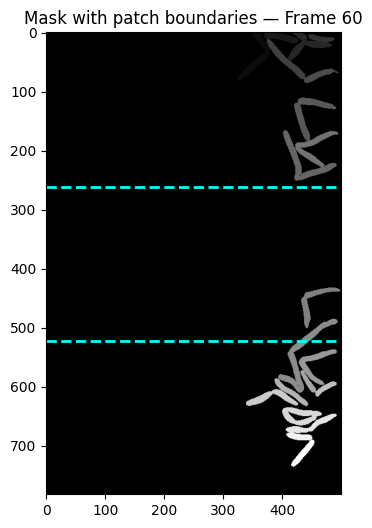

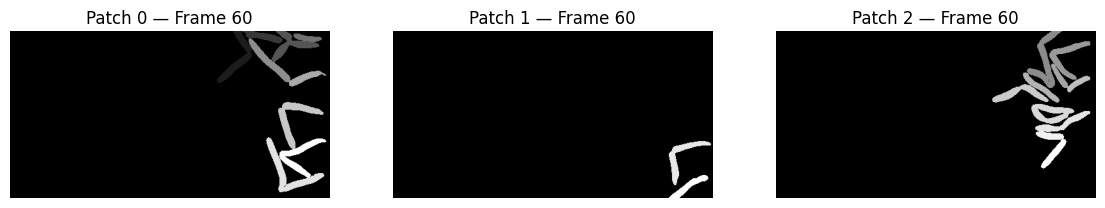


FRAME 120 (End (120))


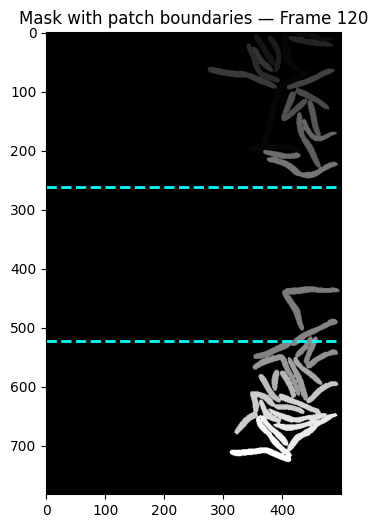

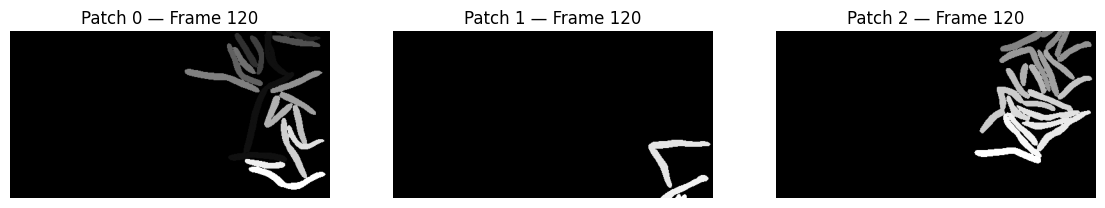

In [ ]:
frame_mid = len(masks) // 2      # middle frame
frame_end = len(masks) - 1       # last frame

frames_to_show = [0, frame_mid, frame_end]
frame_names = ["Start (0)", f"Middle ({frame_mid})", f"End ({frame_end})"]

for idx, f in enumerate(frames_to_show):
    print(f"\nFRAME {f} ({frame_names[idx]})")

    # draw whole mask with horizontal patch-lines
    h, w = masks[f].shape
    patch_h = h // n_patches

    plt.figure(figsize=(7,6))
    plt.imshow(masks[f], cmap="gray")
    plt.title(f"Mask with patch boundaries — Frame {f}")

    # draw horizontal boundaries
    for i in range(1, n_patches):
        y = i * patch_h
        plt.axhline(y=y, color='cyan', linestyle='--', linewidth=2)

    plt.show()

    # show each patch separately
    patches_frame = split_into_patches(masks[f], n_patches=n_patches)

    plt.figure(figsize=(14,4))
    for p in range(n_patches):
        plt.subplot(1, n_patches, p+1)
        plt.imshow(patches_frame[p], cmap="gray")
        plt.title(f"Patch {p} — Frame {f}")
        plt.axis("off")
    plt.show()


The **hotspot** is chosen as the patch with the highest mean growth rate because the region that grows the fastest is the most likely location where resistant or fast-growing cells persist.

In [18]:
patch_mean_growth = []

for p in range(n_patches):
    gr = np.array(patch_growth[p])
    patch_mean_growth.append(np.nanmean(gr))

patch_mean_growth = np.array(patch_mean_growth)
print("Mean growth per patch:", patch_mean_growth)

hotspot_index = np.argmax(patch_mean_growth)
print("Hotspot is patch:", hotspot_index)

Mean growth per patch: [ 0.29255227 -0.09358018  0.40495383]
Hotspot is patch: 2


## Further smoothing


PATCH FITTED AREA STATS
Patch 0: min=24.43, max=77.70, Δ=53.27
Patch 1: min=7.33, max=17.18, Δ=9.85
Patch 2: min=14.99, max=76.67, Δ=61.69

PATCH FITTED GROWTH-RATE STATS
Patch 0: min=0.102, max=0.519
Patch 1: min=-1.486, max=0.350
Patch 2: min=0.158, max=0.986


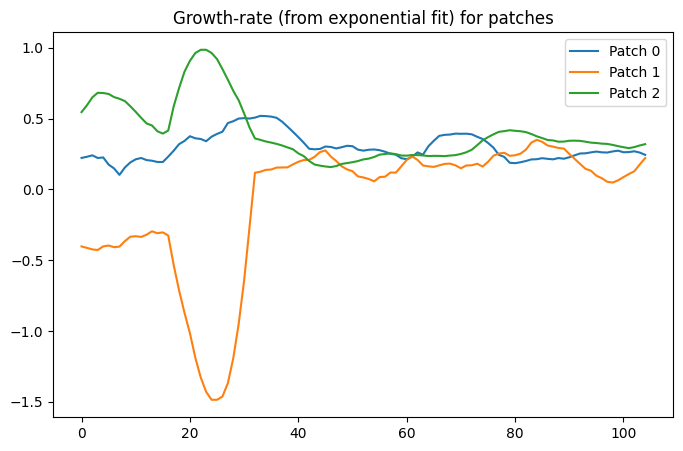

Mean growth per patch: [ 0.29255227 -0.09358018  0.40495383]
Hotspot is patch: 2


In [19]:
patch_fit_areas = []

for patch_id in range(n_patches):

    patch_curve = np.array(patch_areas[patch_id])

    # replicate their 3‒fits logic (the last one overwrites → same as original)
    patch_fit = fit_exponential(patch_curve, rolling_number, 2)
    patch_fit = fit_exponential(patch_curve, rolling_number, 1)
    patch_fit = fit_exponential(patch_curve, rolling_number, 0.5)

    patch_fit_areas.append(patch_fit)

stacked_patch_fit_areas = np.vstack(patch_fit_areas)
print("\nPATCH FITTED AREA STATS")
for p in range(n_patches):
    arr = stacked_patch_fit_areas[p]
    print(f"Patch {p}: min={arr.min():.2f}, max={arr.max():.2f}, Δ={arr.max()-arr.min():.2f}")

patch_fit_growth_rates = []

for patch_fit_curve in stacked_patch_fit_areas:
    gr = calculate_growth_rate_rolling(rolling_number, interval_time, patch_fit_curve)
    patch_fit_growth_rates.append(gr)

print("\nPATCH FITTED GROWTH-RATE STATS")
for p in range(n_patches):
    gr = np.array(patch_fit_growth_rates[p])
    print(f"Patch {p}: min={np.nanmin(gr):.3f}, max={np.nanmax(gr):.3f}")

plt.figure(figsize=(8,5))
for p in range(n_patches):
    plt.plot(patch_fit_growth_rates[p], label=f"Patch {p}")
plt.legend()
plt.title("Growth-rate (from exponential fit) for patches")
plt.show()

patch_mean_growth = []

for p in range(n_patches):
    gr = np.array(patch_growth[p])
    patch_mean_growth.append(np.nanmean(gr))

patch_mean_growth = np.array(patch_mean_growth)
print("Mean growth per patch:", patch_mean_growth)

hotspot_index = np.argmax(patch_mean_growth)
print("Hotspot is patch:", hotspot_index)

# Actual Analysis

This function analyzes growth heterogeneity within a single chamber by dividing the mask into horizontal patches and computing a growth-rate curve for each one.

**The patch with the highest mean growth rate is labeled the hotspot**, representing the region with the strongest and most persistent growth.

Its growth curve is compared with the background, defined as the average of the remaining patches, and with the combined curve obtained from the full chamber area.

In [20]:
def analyze_position_heterogeneity(mask_dir, position,
                                   n_patches=3,
                                   rolling_number=16,
                                   interval_time=2,
                                   pixel_area=0.0733**2):
    """
    Returns:
        hotspot_curve   – growth curve of the fastest patch
        background_curve – mean of the other patches
        combined_curve  – growth curve of full chamber area (no patches)
    """
    # Load all masks for the chamber
    masks = load_chamber(mask_dir, position)

    # Compute area-versus-time curves for each patch (μm²)
    patch_areas = compute_patch_area_curves(masks, pixel_area, n_patches=n_patches)

    # Compute growth-rate curves for each patch
    patch_growth = []
    for p in range(n_patches):
        gr = calculate_growth_rate_rolling(rolling_number, interval_time, patch_areas[p])
        patch_growth.append(gr)

    # Identify hotspot as the patch with highest mean growth
    patch_means = [np.nanmean(pg) for pg in patch_growth]
    hotspot_idx = np.argmax(patch_means)

    # Growth-rate curve of hotspot patch
    hotspot_curve = patch_growth[hotspot_idx]

    # Background = mean growth of all other patches
    non_hotspot = [patch_growth[i] for i in range(n_patches) if i != hotspot_idx]
    background_curve = np.nanmean(non_hotspot, axis=0)

    # Combined curve = growth-rate from total chamber area
    full_area = np.sum(patch_areas, axis=0)
    combined_curve = calculate_growth_rate_rolling(rolling_number, interval_time, full_area)

    return hotspot_curve, background_curve, combined_curve


This step applies the heterogeneity analysis to all **reference** chambers (positions 101–110).

In [22]:
ref_dir = "/content/drive/MyDrive/REF_masks101_110"

ref_positions = list(range(101, 111))

ref_hotspots = []
ref_background = []
ref_combined  = []

# Run heterogeneity analysis for every reference chamber
for pos in ref_positions:
    print(f"REF position {pos}")

    # hs = hotspot curve, bg = background curve, comb = full-area curve
    hs, bg, comb = analyze_position_heterogeneity(
        ref_dir, pos,
        n_patches=3,
        rolling_number=rolling_number,
        interval_time=interval_time,
        pixel_area=pixel_area
    )

    ref_hotspots.append(hs)
    ref_background.append(bg)
    ref_combined.append(comb)

ref_hotspots   = np.vstack(ref_hotspots)
ref_background = np.vstack(ref_background)
ref_combined   = np.vstack(ref_combined)


REF position 101


Loading Pos101: 100%|██████████| 121/121 [00:01<00:00, 112.71it/s]


REF position 102


Loading Pos102: 100%|██████████| 121/121 [00:01<00:00, 116.15it/s]


REF position 103


Loading Pos103: 100%|██████████| 121/121 [00:01<00:00, 115.98it/s]


REF position 104


Loading Pos104: 100%|██████████| 121/121 [01:17<00:00,  1.56it/s]


REF position 105


Loading Pos105: 100%|██████████| 121/121 [00:43<00:00,  2.80it/s]


REF position 106


Loading Pos106: 100%|██████████| 121/121 [01:20<00:00,  1.49it/s]


REF position 107


Loading Pos107: 100%|██████████| 121/121 [00:52<00:00,  2.31it/s]


REF position 108


Loading Pos108: 100%|██████████| 121/121 [02:00<00:00,  1.00it/s]


REF position 109


Loading Pos109: 100%|██████████| 121/121 [01:02<00:00,  1.95it/s]


REF position 110


Loading Pos110: 100%|██████████| 121/121 [01:49<00:00,  1.10it/s]


This step applies the heterogeneity analysis to all **treatment** chambers (positions 201–210).

In [23]:
treat_dir = "/content/drive/MyDrive/RIF10_masks201_210"

treat_positions = list(range(201, 211))
treat_empty = []

treat_hotspots = []
treat_background = []
treat_combined = []

# Run heterogeneity analysis for every treatment chamber
for pos in treat_positions:
    if pos in treat_empty:
        continue

    print(f"TREAT position {pos}")

    hs, bg, comb = analyze_position_heterogeneity(
        treat_dir, pos,
        n_patches=3,
        rolling_number=rolling_number,
        interval_time=interval_time,
        pixel_area=pixel_area
    )

    treat_hotspots.append(hs)
    treat_background.append(bg)
    treat_combined.append(comb)

treat_hotspots   = np.vstack(treat_hotspots)
treat_background = np.vstack(treat_background)
treat_combined   = np.vstack(treat_combined)


TREAT position 201


Loading Pos201: 100%|██████████| 121/121 [01:45<00:00,  1.15it/s]


TREAT position 202


Loading Pos202: 100%|██████████| 121/121 [01:52<00:00,  1.07it/s]


TREAT position 203


Loading Pos203: 100%|██████████| 121/121 [00:47<00:00,  2.55it/s]


TREAT position 204


Loading Pos204: 100%|██████████| 121/121 [01:48<00:00,  1.11it/s]


TREAT position 205


Loading Pos205: 100%|██████████| 121/121 [00:45<00:00,  2.65it/s]


TREAT position 206


Loading Pos206: 100%|██████████| 121/121 [01:45<00:00,  1.15it/s]


TREAT position 207


Loading Pos207: 100%|██████████| 121/121 [01:51<00:00,  1.08it/s]


TREAT position 208


Loading Pos208: 100%|██████████| 121/121 [01:07<00:00,  1.79it/s]


TREAT position 209


Loading Pos209: 100%|██████████| 121/121 [01:36<00:00,  1.26it/s]


TREAT position 210


Loading Pos210: 100%|██████████| 121/121 [00:32<00:00,  3.71it/s]


**Mean, standard deviation, and SEM** are computed for the growth-rate curves of the reference chambers, and for the treatment chambers these statistics are calculated separately for the full-area signal, the hotspot regions, and the background regions.

In [24]:
# Compute mean, standard deviation, and SEM for REF full-area growth curves (combined only)
ref_mean, ref_std, ref_sem = find_means_std_sem(ref_combined)

# Compute statistics for TREAT full-area, hotspot, and background curves
treat_comb_mean, treat_comb_std, treat_comb_sem = find_means_std_sem(treat_combined)
treat_hs_mean,   treat_hs_std,   treat_hs_sem   = find_means_std_sem(treat_hotspots)
treat_bg_mean,   treat_bg_std,   treat_bg_sem   = find_means_std_sem(treat_background)


The treatment and reference growth-rate curves are **normalized** by dividing each curve by the **reference mean** at every time point.

In [25]:
# Normalize reference curve to itself → becomes 1.0 everywhere
norm_ref       = normalize_lists(ref_mean, ref_mean)

# Normalize treatment curves using the reference mean
norm_comb      = normalize_lists(treat_comb_mean, ref_mean)
norm_hs        = normalize_lists(treat_hs_mean, ref_mean)
norm_bg        = normalize_lists(treat_bg_mean, ref_mean)

# Normalize SEM values the same way
norm_ref_sem   = normalize_lists(ref_sem, ref_mean)
norm_comb_sem  = normalize_lists(treat_comb_sem, ref_mean)
norm_hs_sem    = normalize_lists(treat_hs_sem, ref_mean)
norm_bg_sem    = normalize_lists(treat_bg_sem, ref_mean)

The normalized reference, treatment, hotspot, and background growth-rate curves are aligned to the same time axis and plotted together to visualize spatial heterogeneity.

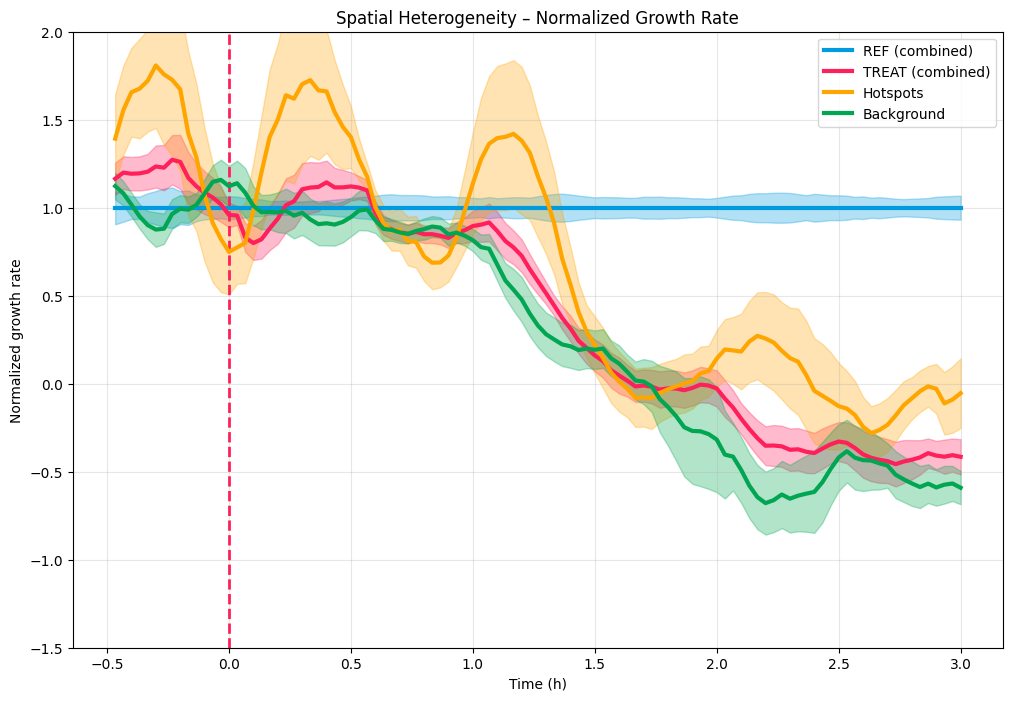

In [26]:
# Convert to numpy arrays
norm_ref      = np.array(norm_ref)
norm_comb     = np.array(norm_comb)
norm_hs       = np.array(norm_hs)
norm_bg       = np.array(norm_bg)

norm_ref_sem  = np.array(norm_ref_sem)
norm_comb_sem = np.array(norm_comb_sem)
norm_hs_sem   = np.array(norm_hs_sem)
norm_bg_sem   = np.array(norm_bg_sem)

num_frames = len(norm_ref) + rolling_number
time_plot = np.array([t*(interval_time/60) - 1 for t in range(num_frames)])
time_plot = time_plot[rolling_number:]   # align to growth-rate arrays

plt.figure(figsize=(12,8), facecolor="white")
plt.axvline(x=0, color="#FF1F5B", linestyle="--", lw=2)

# REF (blue)
plt.plot(time_plot, norm_ref, lw=3, color="#009ADE", label="REF (combined)")
plt.fill_between(time_plot, norm_ref - norm_ref_sem, norm_ref + norm_ref_sem,
                 alpha=0.3, color="#009ADE")

# TREAT combined
plt.plot(time_plot, norm_comb, lw=3, color="#FF1F5B", label="TREAT (combined)")
plt.fill_between(time_plot, norm_comb - norm_comb_sem, norm_comb + norm_comb_sem,
                 alpha=0.3, color="#FF1F5B")

# Hotspots
plt.plot(time_plot, norm_hs, lw=3, color="#FFA500", label="Hotspots")
plt.fill_between(time_plot, norm_hs - norm_hs_sem, norm_hs + norm_hs_sem,
                 alpha=0.3, color="#FFA500")

# Background
plt.plot(time_plot, norm_bg, lw=3, color="#00A651", label="Background")
plt.fill_between(time_plot, norm_bg - norm_bg_sem, norm_bg + norm_bg_sem,
                 alpha=0.3, color="#00A651")

plt.xlabel("Time (h)")
plt.ylabel("Normalized growth rate")
plt.title("Spatial Heterogeneity – Normalized Growth Rate")
plt.legend()
plt.ylim(-1.5, 2)
plt.grid(alpha=0.3)
plt.show()


# Further Inspection

To **visually assess** whether the assigned hotspot regions are meaningful, the hotspot for each chamber is first identified.

In [67]:
def find_hotspot_for_position(mask_dir, position, pixel_area, rolling_number, interval_time, n_patches=3):
    # Load mask stack
    masks = load_chamber(mask_dir, position)   # (T, H, W)

    # Compute patch areas (µm²)
    patch_areas = compute_patch_area_curves(masks, pixel_area, n_patches=n_patches)  # (n_patches, T)

    # Compute growth rates per patch
    patch_growth = []
    for p in range(n_patches):
        gr = calculate_growth_rate_rolling(
            rolling_number,
            interval_time,
            patch_areas[p]   # already in µm²
        )
        patch_growth.append(np.array(gr))

    # Mean growth per patch (over entire time, or you can restrict to post-drug)
    patch_mean_growth = np.array([np.nanmean(gr) for gr in patch_growth])

    # Hotspot = patch with max mean growth
    hotspot_idx = np.nanargmax(patch_mean_growth)

    return hotspot_idx, patch_mean_growth, patch_growth


In [68]:
ref_positions = list(range(101, 111))
ref_hotspot_indices = []

for pos in ref_positions:
    hs_idx, patch_mean_growth, patch_growth = find_hotspot_for_position(
        ref_dir, pos, pixel_area, rolling_number, interval_time, n_patches=3
    )
    print(f"REF Pos {pos}: hotspot patch = {hs_idx}, mean growth = {patch_mean_growth[hs_idx]:.3f} h⁻¹")
    ref_hotspot_indices.append(hs_idx)


Loading Pos101: 100%|██████████| 121/121 [00:02<00:00, 59.14it/s]


REF Pos 101: hotspot patch = 2, mean growth = 0.405 h⁻¹


Loading Pos102: 100%|██████████| 121/121 [00:01<00:00, 94.91it/s] 


REF Pos 102: hotspot patch = 0, mean growth = 0.328 h⁻¹


Loading Pos103: 100%|██████████| 121/121 [00:01<00:00, 91.23it/s] 


REF Pos 103: hotspot patch = 2, mean growth = 0.358 h⁻¹


Loading Pos104: 100%|██████████| 121/121 [00:03<00:00, 39.56it/s]


REF Pos 104: hotspot patch = 1, mean growth = 0.448 h⁻¹


Loading Pos105: 100%|██████████| 121/121 [00:01<00:00, 110.12it/s]


REF Pos 105: hotspot patch = 1, mean growth = 0.286 h⁻¹


Loading Pos106: 100%|██████████| 121/121 [00:01<00:00, 115.45it/s]


REF Pos 106: hotspot patch = 1, mean growth = 0.277 h⁻¹


Loading Pos107: 100%|██████████| 121/121 [00:01<00:00, 115.09it/s]


REF Pos 107: hotspot patch = 2, mean growth = 0.281 h⁻¹


Loading Pos108: 100%|██████████| 121/121 [00:01<00:00, 109.52it/s]


REF Pos 108: hotspot patch = 1, mean growth = 0.333 h⁻¹


Loading Pos109: 100%|██████████| 121/121 [00:01<00:00, 115.43it/s]


REF Pos 109: hotspot patch = 2, mean growth = 0.316 h⁻¹


Loading Pos110: 100%|██████████| 121/121 [00:01<00:00, 94.01it/s] 


REF Pos 110: hotspot patch = 0, mean growth = 0.389 h⁻¹


In [70]:
treat_positions =list(range(201, 211))
treat_hotspot_indices = []

for pos in treat_positions:
    hs_idx, patch_mean_growth, patch_growth = find_hotspot_for_position(
        treat_dir, pos, pixel_area, rolling_number, interval_time, n_patches=3
    )
    print(f"TREAT Pos {pos}: hotspot patch = {hs_idx}, mean growth = {patch_mean_growth[hs_idx]:.3f} h⁻¹")
    treat_hotspot_indices.append(hs_idx)


Loading Pos201: 100%|██████████| 121/121 [00:01<00:00, 62.27it/s]


TREAT Pos 201: hotspot patch = 2, mean growth = 0.142 h⁻¹


Loading Pos202: 100%|██████████| 121/121 [00:01<00:00, 89.01it/s] 


TREAT Pos 202: hotspot patch = 0, mean growth = 0.141 h⁻¹


Loading Pos203: 100%|██████████| 121/121 [00:01<00:00, 98.00it/s]


TREAT Pos 203: hotspot patch = 1, mean growth = 0.064 h⁻¹


Loading Pos204: 100%|██████████| 121/121 [00:01<00:00, 111.24it/s]


TREAT Pos 204: hotspot patch = 2, mean growth = 0.122 h⁻¹


Loading Pos205: 100%|██████████| 121/121 [00:01<00:00, 114.05it/s]


TREAT Pos 205: hotspot patch = 0, mean growth = 0.191 h⁻¹


Loading Pos206: 100%|██████████| 121/121 [00:00<00:00, 140.18it/s]


TREAT Pos 206: hotspot patch = 0, mean growth = 0.138 h⁻¹


Loading Pos207: 100%|██████████| 121/121 [00:00<00:00, 133.29it/s]


TREAT Pos 207: hotspot patch = 0, mean growth = 0.106 h⁻¹


Loading Pos208: 100%|██████████| 121/121 [00:00<00:00, 125.09it/s]


TREAT Pos 208: hotspot patch = 0, mean growth = 0.271 h⁻¹


Loading Pos209: 100%|██████████| 121/121 [00:01<00:00, 116.68it/s]


TREAT Pos 209: hotspot patch = 0, mean growth = 0.265 h⁻¹


Loading Pos210: 100%|██████████| 121/121 [00:01<00:00, 111.23it/s]


TREAT Pos 210: hotspot patch = 0, mean growth = 0.251 h⁻¹


This function visualizes the hotspot assignment for each chamber by showing all horizontal patches at the **first, middle, and last frame**.

In [ ]:
def show_patches_with_hotspot(mask_dir, position, hotspot_idx, n_patches=3):
    """
    Show each patch (0..n_patches-1) at first, middle, and last frames.
    Highlight hotspot patch using a cyan overlay.
    """
    # Load chamber masks
    masks = load_chamber(mask_dir, position)
    T, H, W = masks.shape

    # Frames to display
    frames = [0, T//2, T-1]
    titles = ["First", "Middle", "Last"]

    plt.figure(figsize=(12, 10))

    for p in range(n_patches):

        for j, frame_idx in enumerate(frames):

            patch = split_into_patches(masks[frame_idx], n_patches)[p]

            # Convert to RGB so we can overlay color
            patch_rgb = np.stack([patch, patch, patch], axis=-1).astype(float)

            # Highlight hotspot patch
            if p == hotspot_idx:
                overlay = patch_rgb.copy()
                # Cyan overlay (0, 255, 255)
                overlay[:, :, 0] *= 0.3   # reduce red channel
                overlay[:, :, 1] = patch_rgb[:, :, 1] + 150
                overlay[:, :, 2] = patch_rgb[:, :, 2] + 150

                alpha = 0.35
                patch_rgb = (1-alpha) * patch_rgb + alpha * overlay

            # Normalize for display
            if np.max(patch_rgb) > 0:
                patch_rgb = patch_rgb / np.max(patch_rgb)

            # Plot patch
            idx = p * 3 + j + 1
            plt.subplot(n_patches, 3, idx)
            plt.imshow(patch_rgb)
            plt.axis("off")

            if j == 0:
                plt.ylabel(f"Patch {p}", fontsize=12)
            if p == 0:
                plt.title(titles[j], fontsize=12)

    plt.suptitle(f"Position {position} – Hotspot = Patch {hotspot_idx}", fontsize=14)
    plt.tight_layout()
    plt.show()


Visualization for each reference chamber. In most positions, the **highlighted region** visually corresponds to the area with the strongest growth.

Showing hotspot for position 101


Loading Pos101: 100%|██████████| 121/121 [00:01<00:00, 113.14it/s]


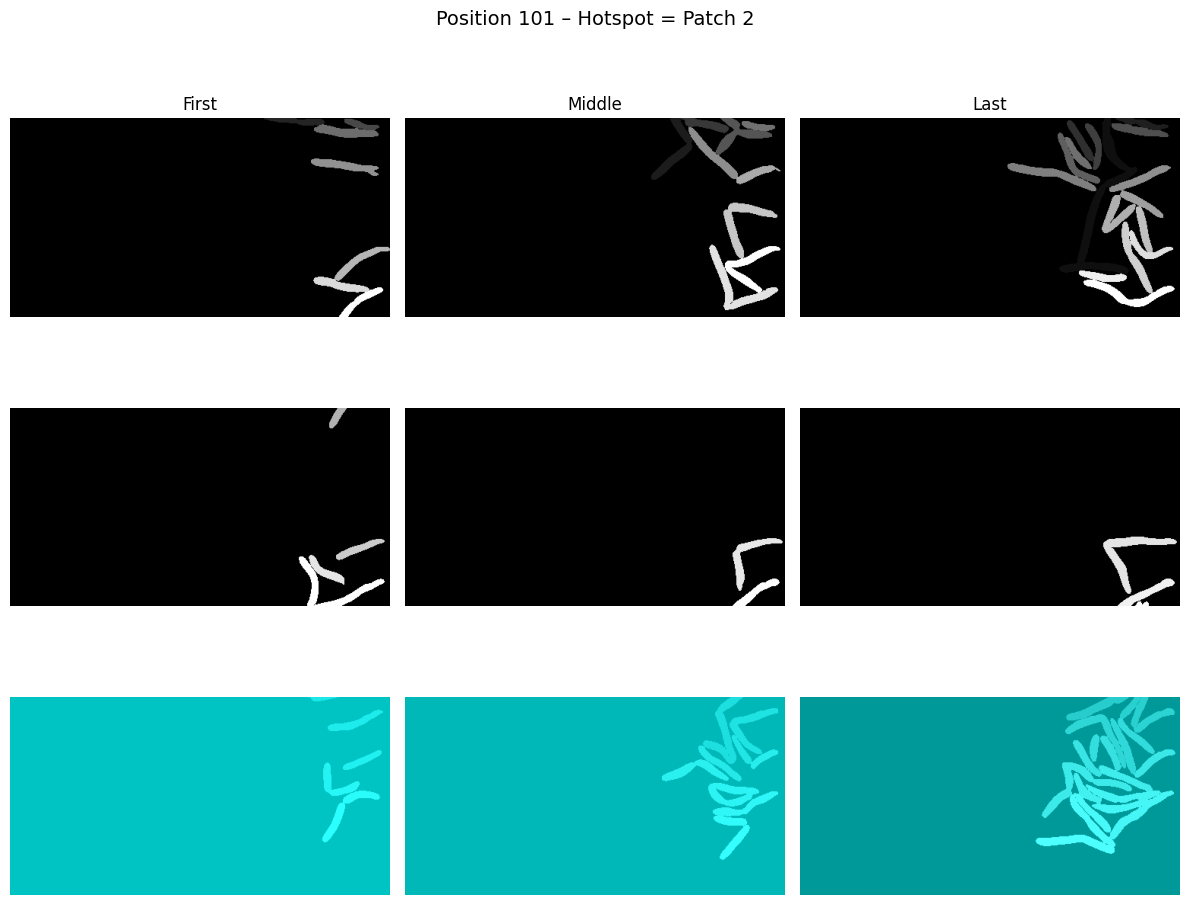

Showing hotspot for position 102


Loading Pos102: 100%|██████████| 121/121 [00:01<00:00, 67.06it/s]


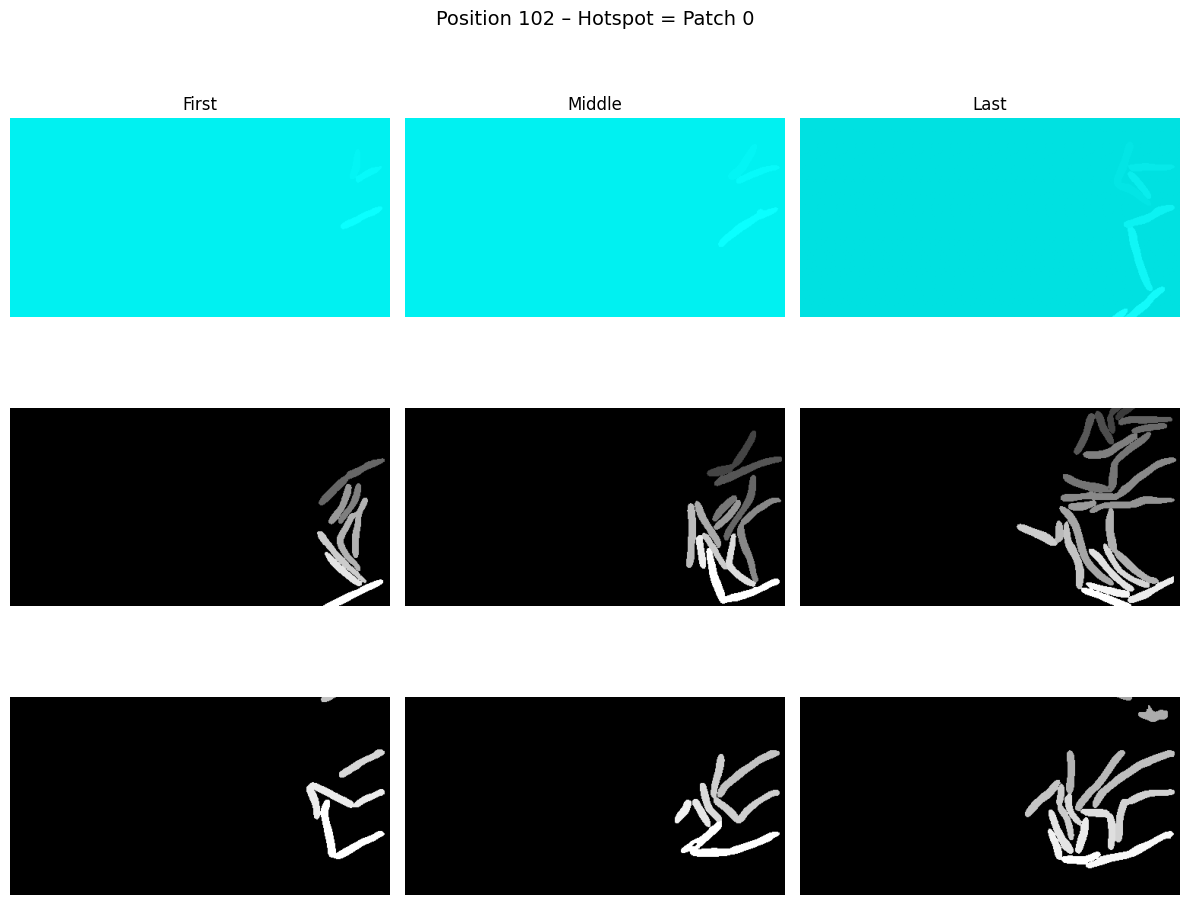

Showing hotspot for position 103


Loading Pos103: 100%|██████████| 121/121 [00:01<00:00, 72.59it/s]


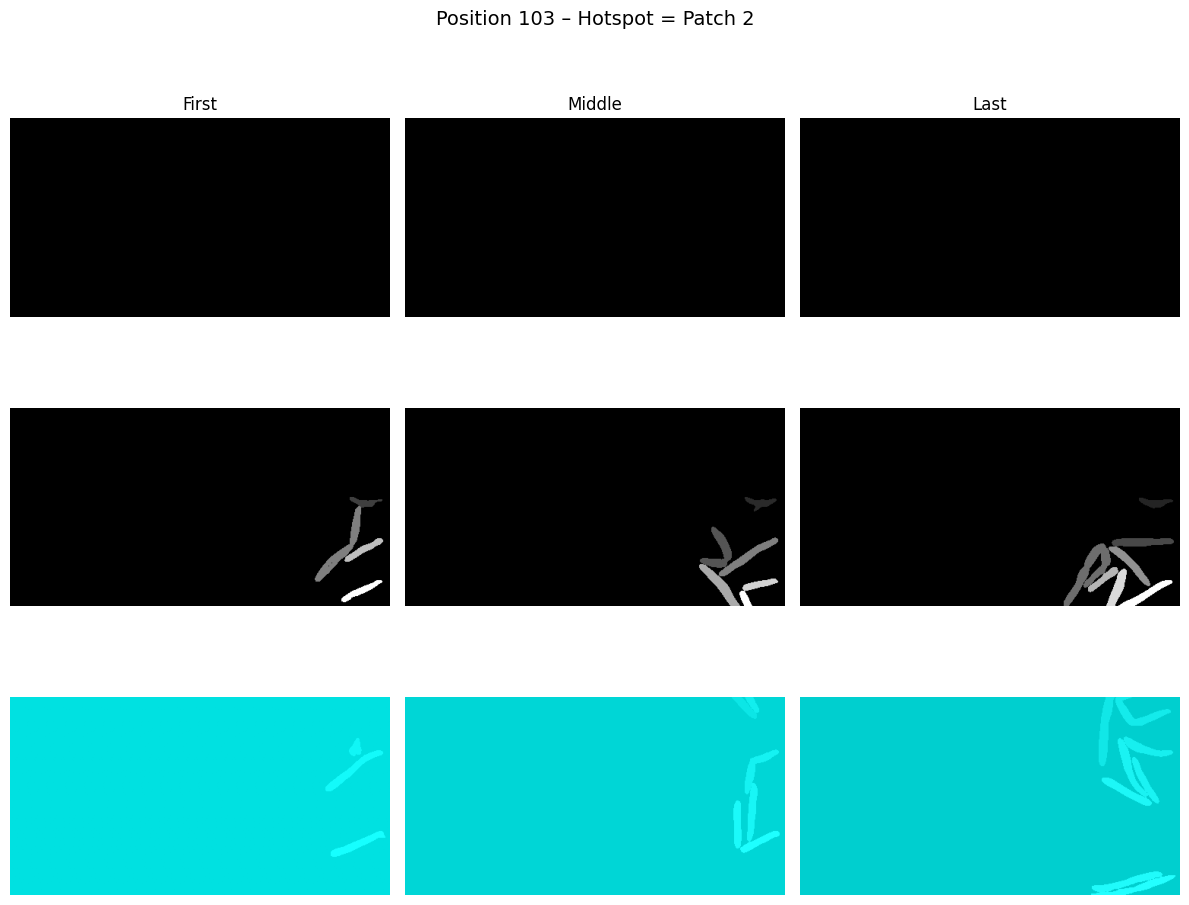

Showing hotspot for position 104


Loading Pos104: 100%|██████████| 121/121 [00:01<00:00, 78.27it/s]


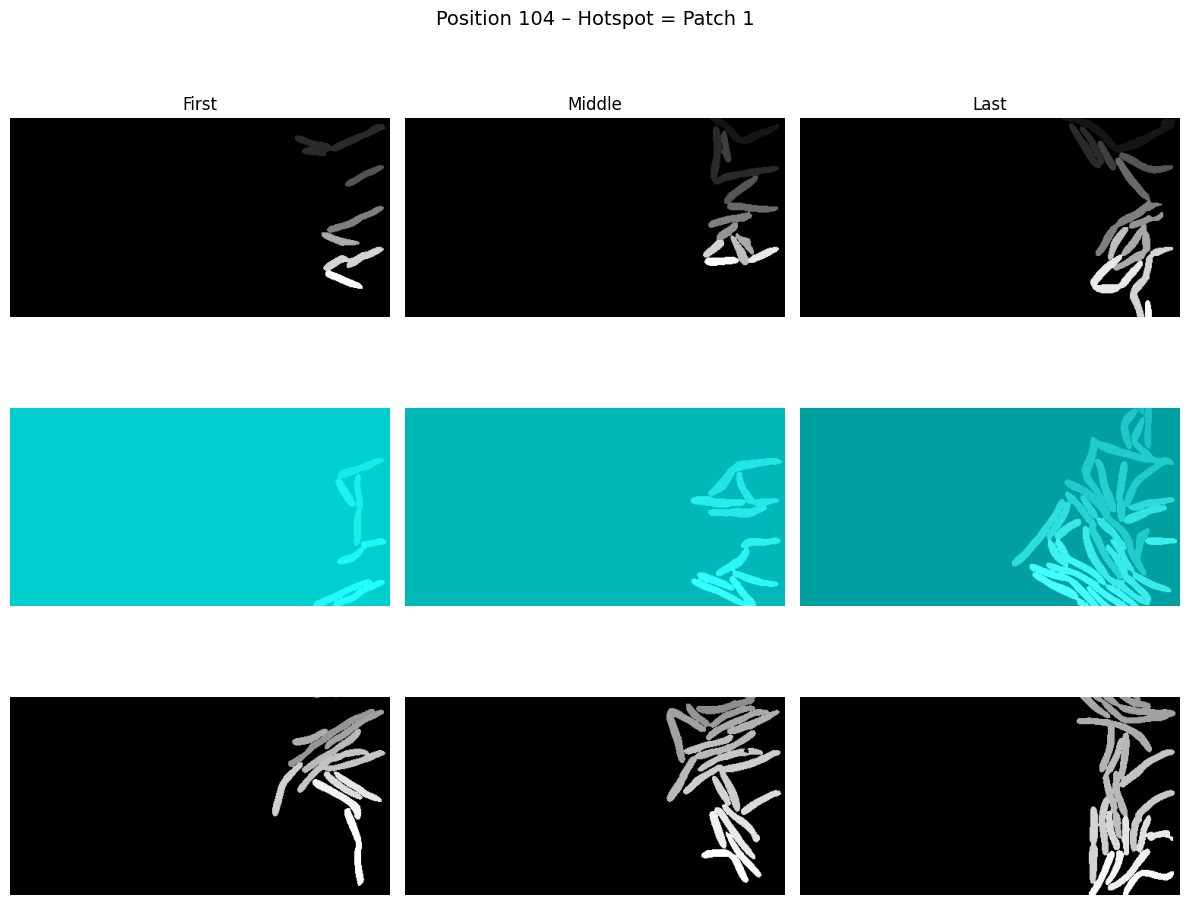

Showing hotspot for position 105


Loading Pos105: 100%|██████████| 121/121 [00:00<00:00, 133.48it/s]


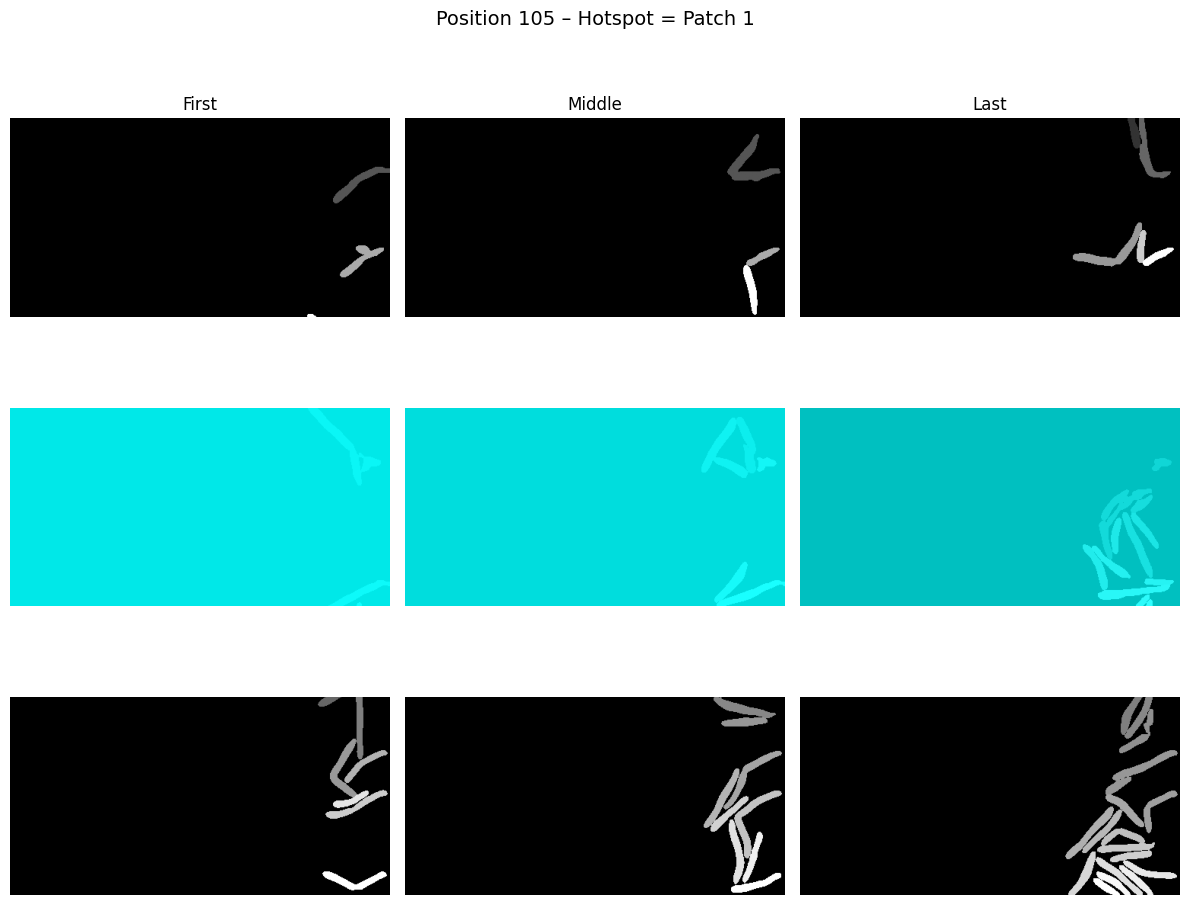

Showing hotspot for position 106


Loading Pos106: 100%|██████████| 121/121 [00:00<00:00, 139.46it/s]


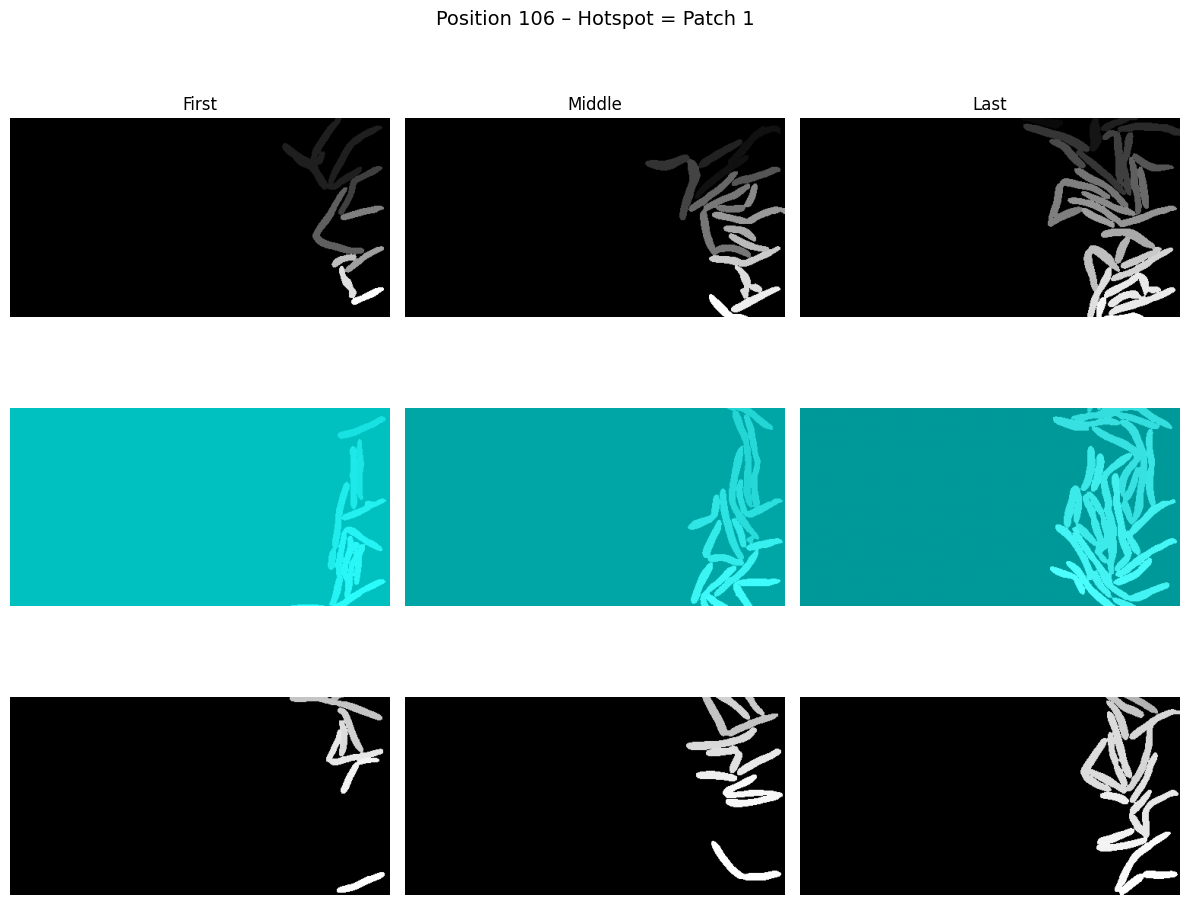

Showing hotspot for position 107


Loading Pos107: 100%|██████████| 121/121 [00:00<00:00, 134.90it/s]


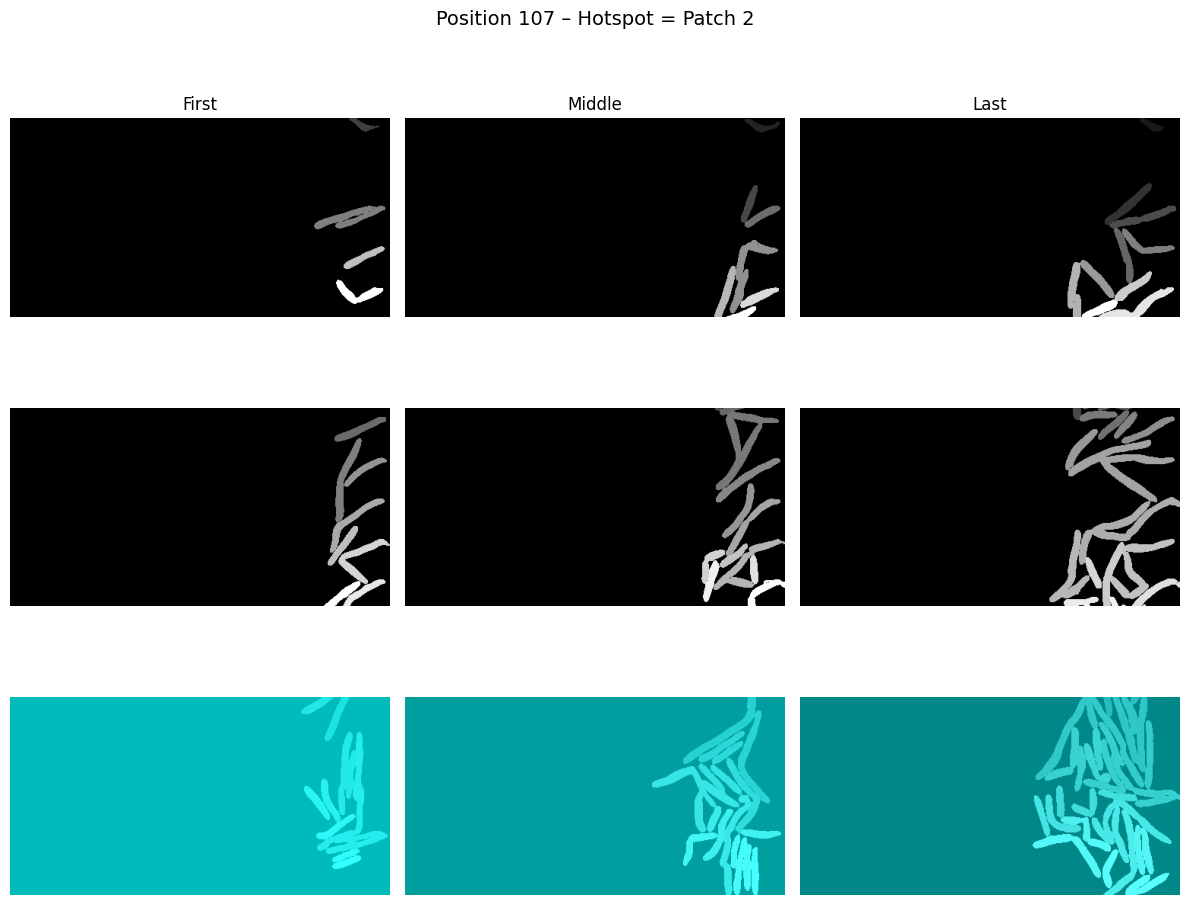

Showing hotspot for position 108


Loading Pos108: 100%|██████████| 121/121 [00:00<00:00, 135.28it/s]


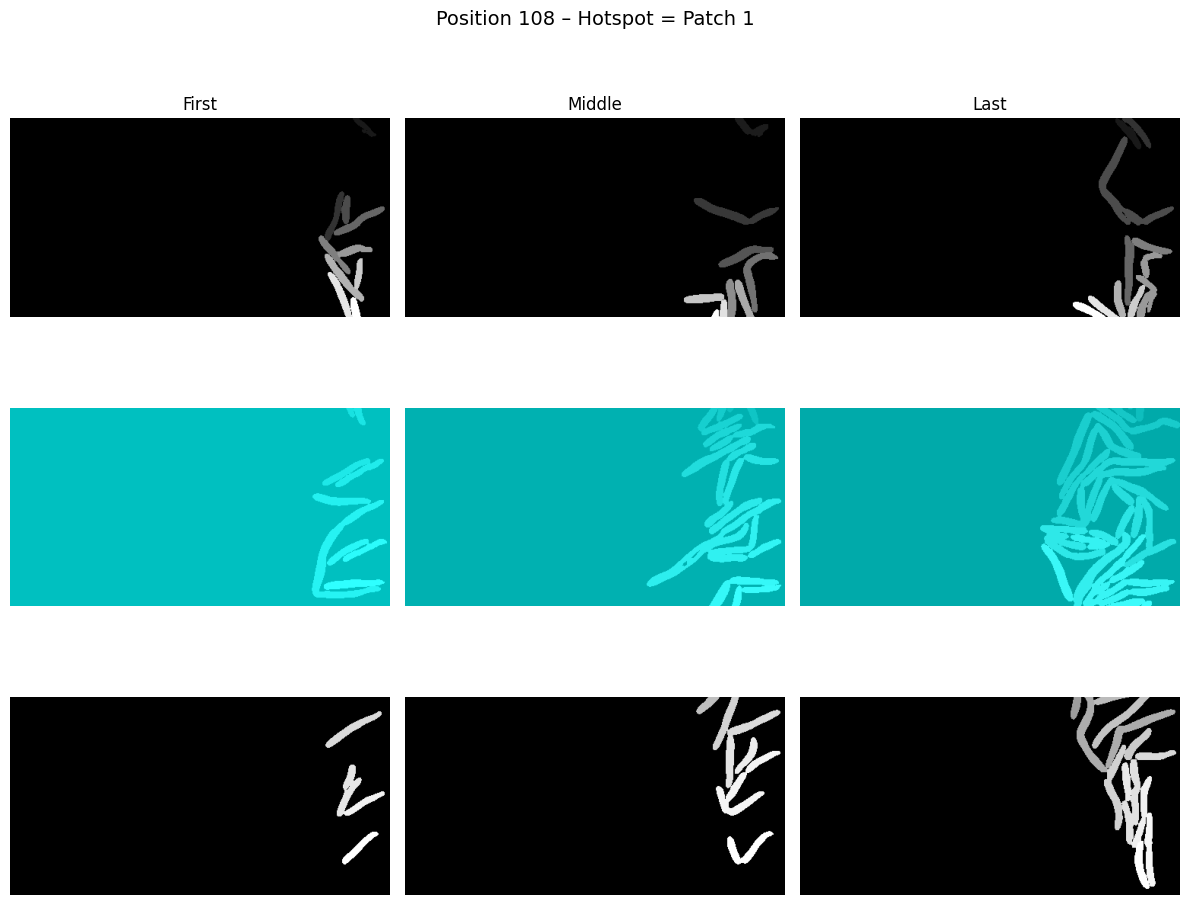

Showing hotspot for position 109


Loading Pos109: 100%|██████████| 121/121 [00:00<00:00, 124.53it/s]


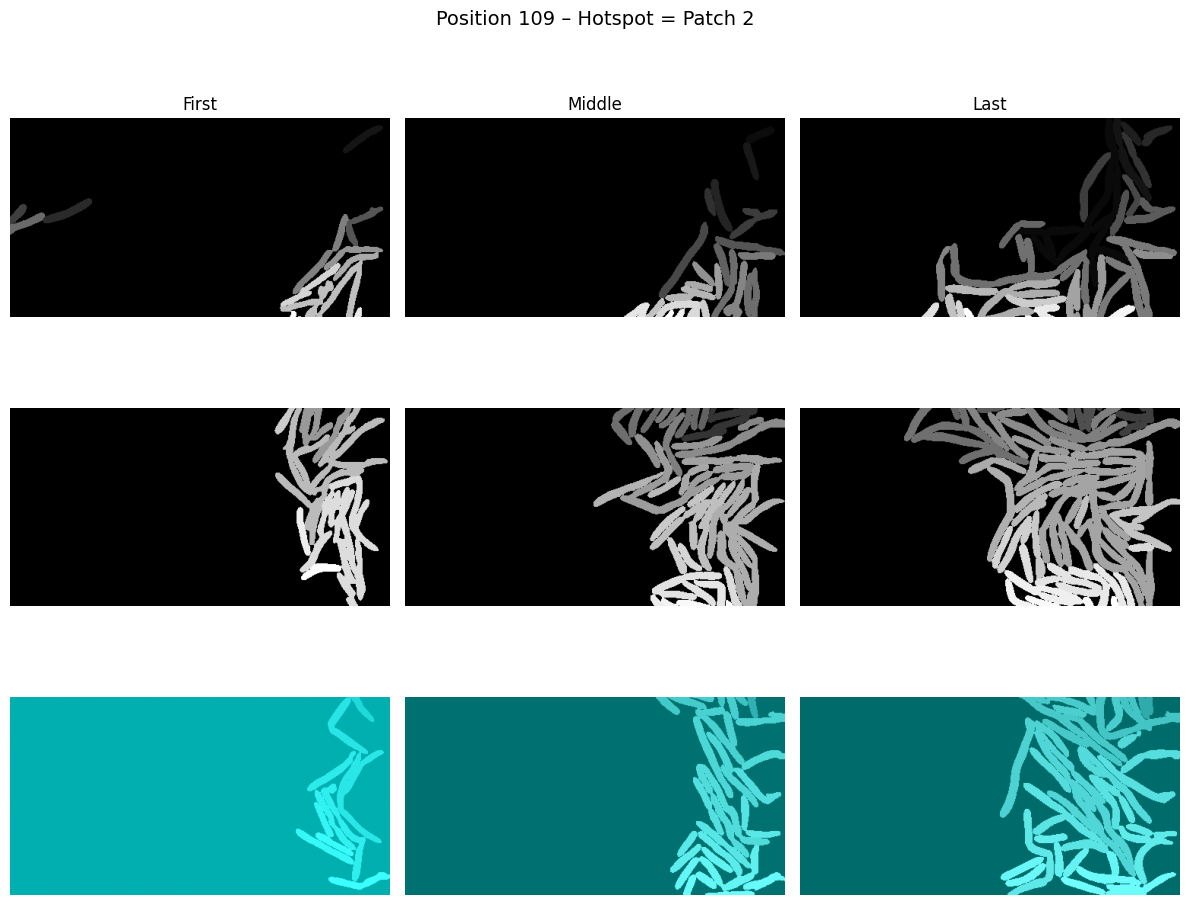

Showing hotspot for position 110


Loading Pos110: 100%|██████████| 121/121 [00:00<00:00, 123.44it/s]


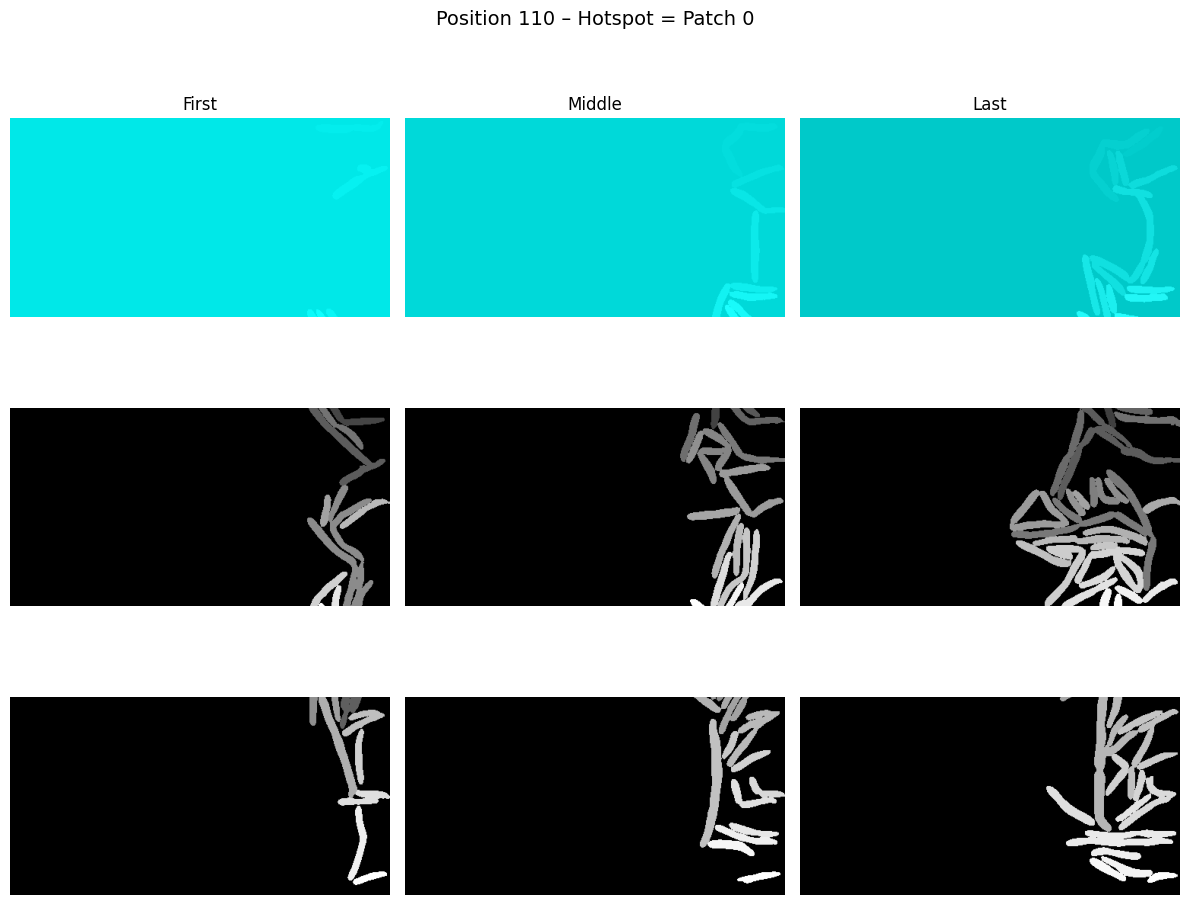

In [81]:
ref_positions = list(range(101, 111))

# Hotspots
ref_hotspot_indices = {
    101: 2, 102: 0, 103: 2, 104: 1, 105: 1,
    106: 1, 107: 2, 108: 1, 109: 2, 110: 0
}

for pos in ref_positions:
    print(f"Showing hotspot for position {pos}")
    show_patches_with_hotspot(ref_dir, pos, ref_hotspot_indices[pos], n_patches=3)


The same holds for the treated positions.

Showing hotspot for position 201


Loading Pos201: 100%|██████████| 121/121 [00:01<00:00, 91.11it/s] 


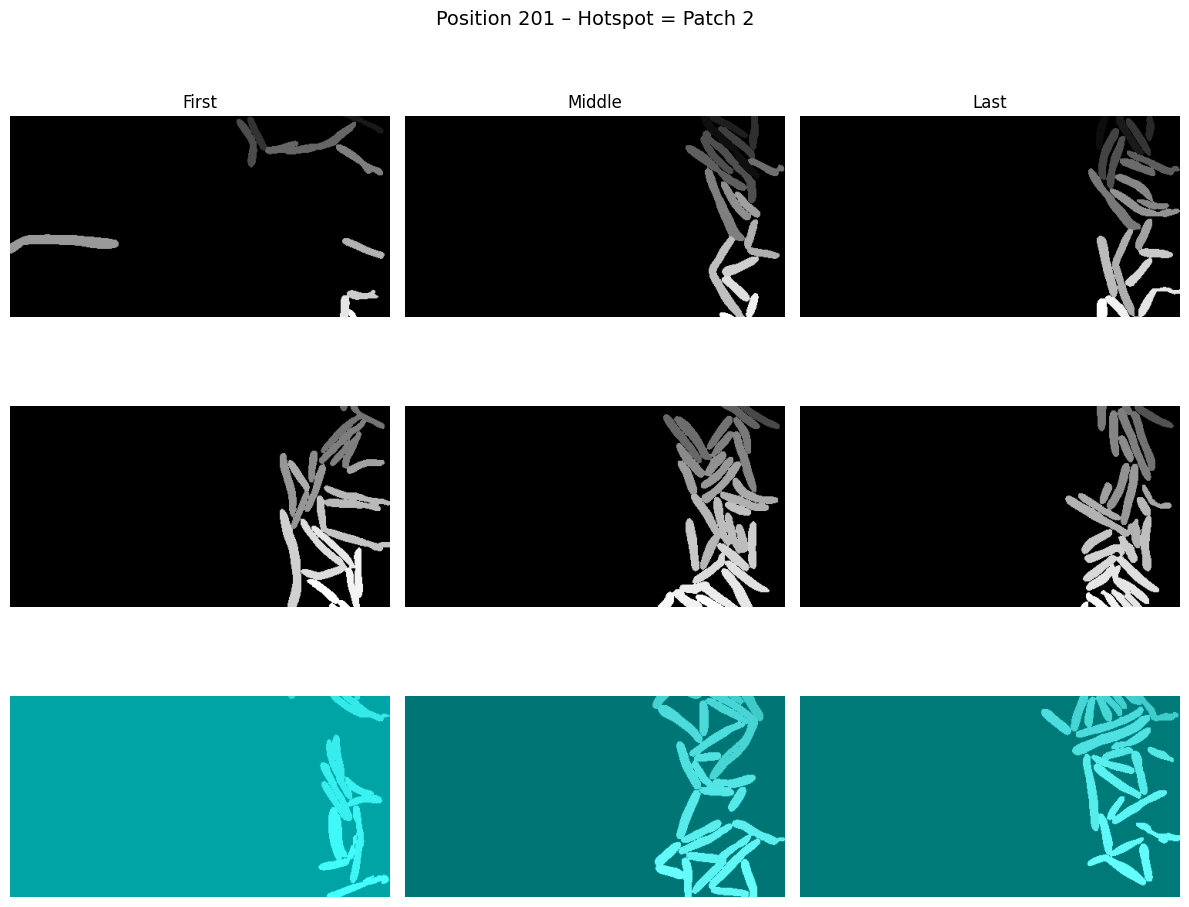

Showing hotspot for position 202


Loading Pos202: 100%|██████████| 121/121 [00:01<00:00, 91.24it/s] 


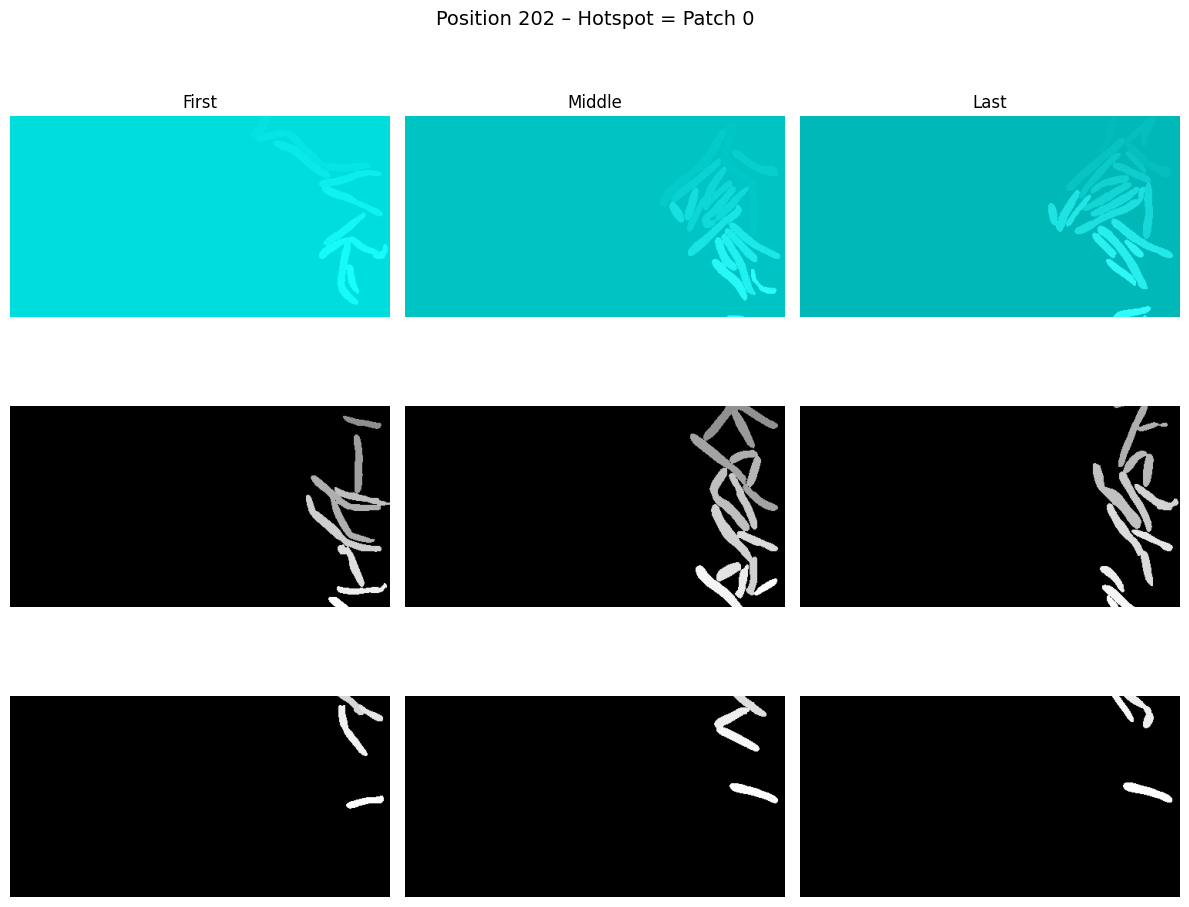

Showing hotspot for position 203


Loading Pos203: 100%|██████████| 121/121 [00:01<00:00, 67.54it/s] 


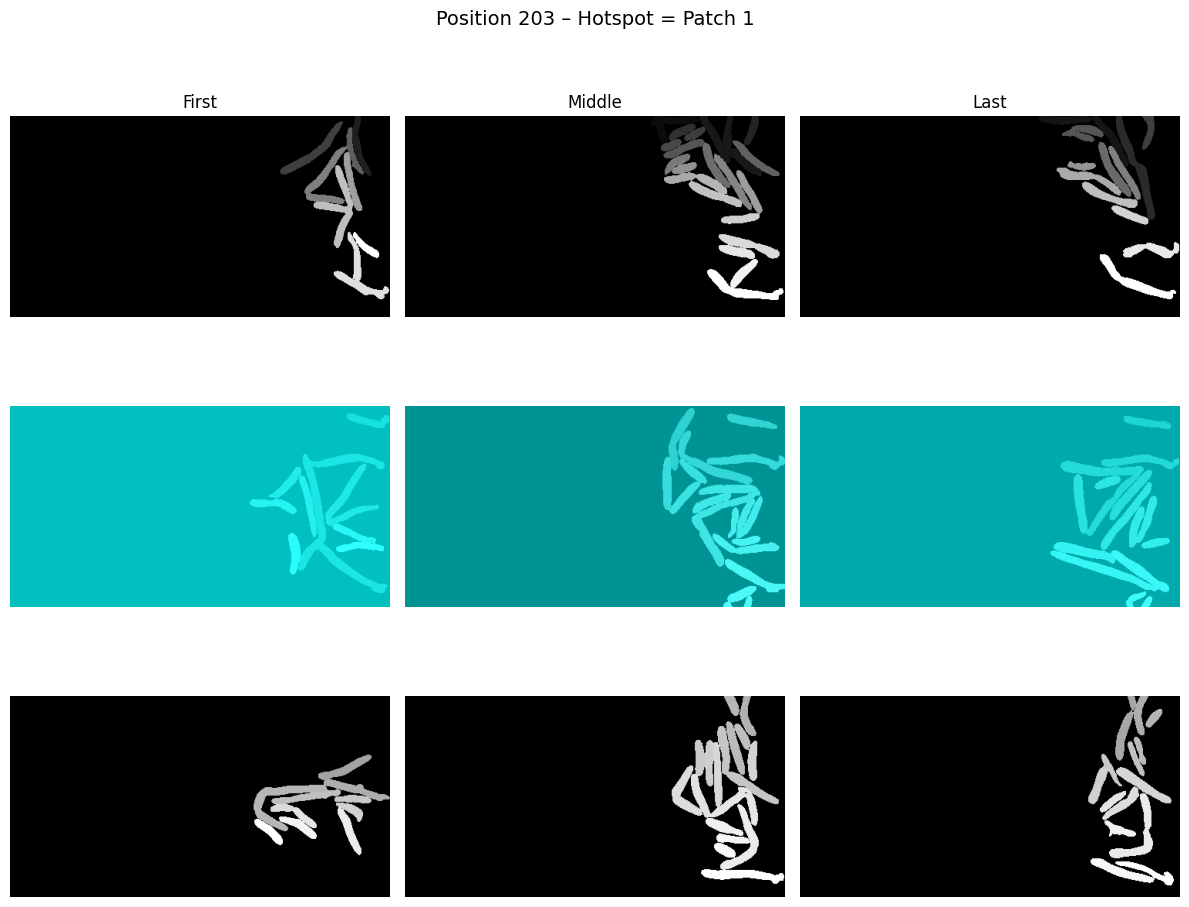

Showing hotspot for position 204


Loading Pos204: 100%|██████████| 121/121 [00:02<00:00, 46.74it/s]


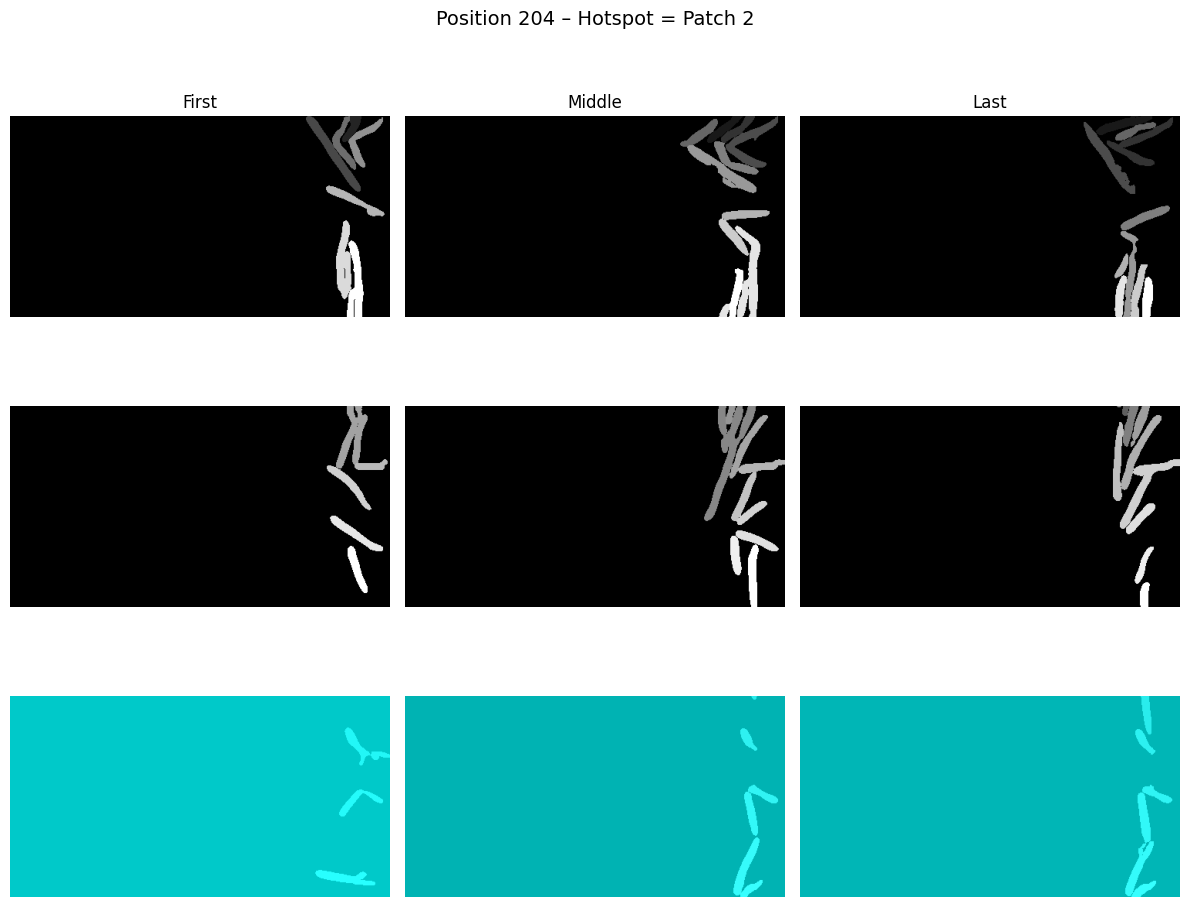

Showing hotspot for position 205


Loading Pos205: 100%|██████████| 121/121 [00:01<00:00, 93.37it/s] 


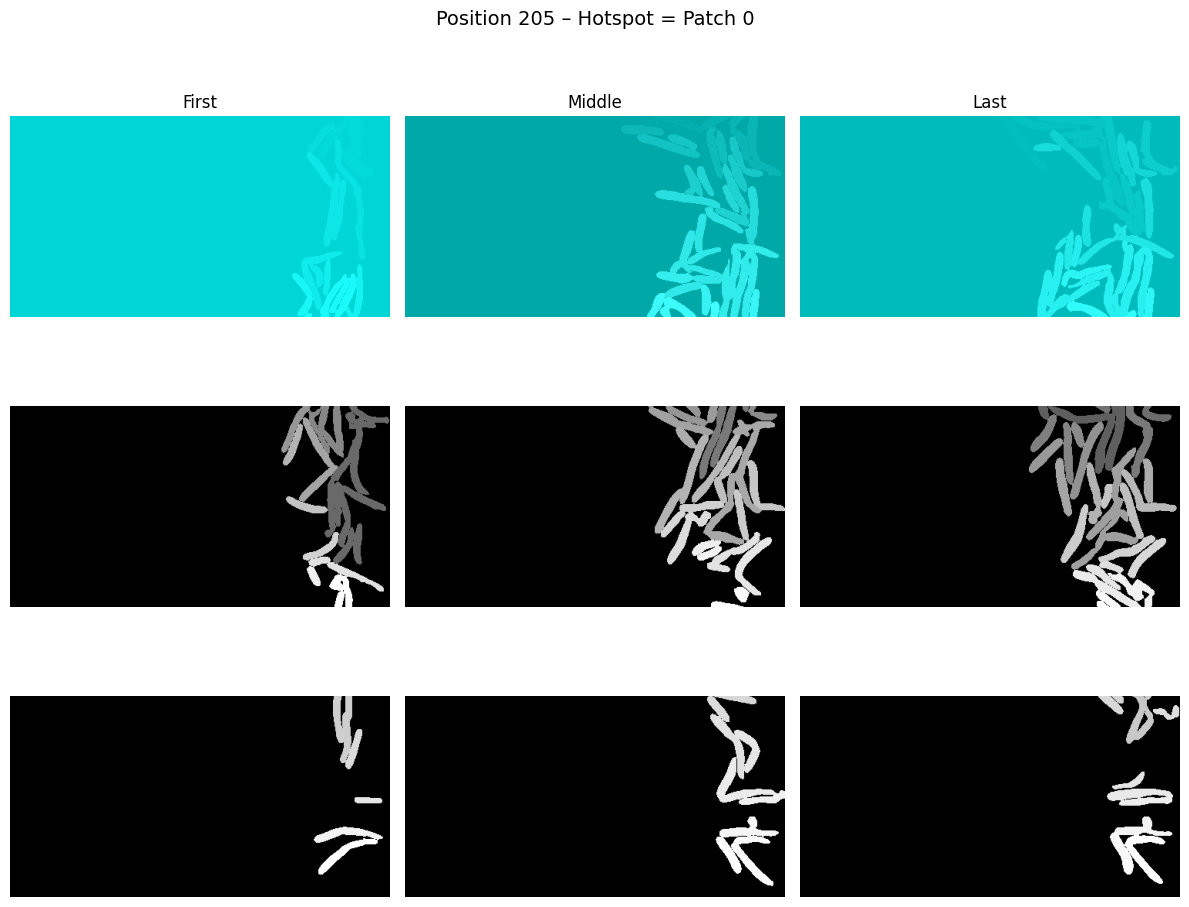

Showing hotspot for position 206


Loading Pos206: 100%|██████████| 121/121 [00:01<00:00, 109.74it/s]


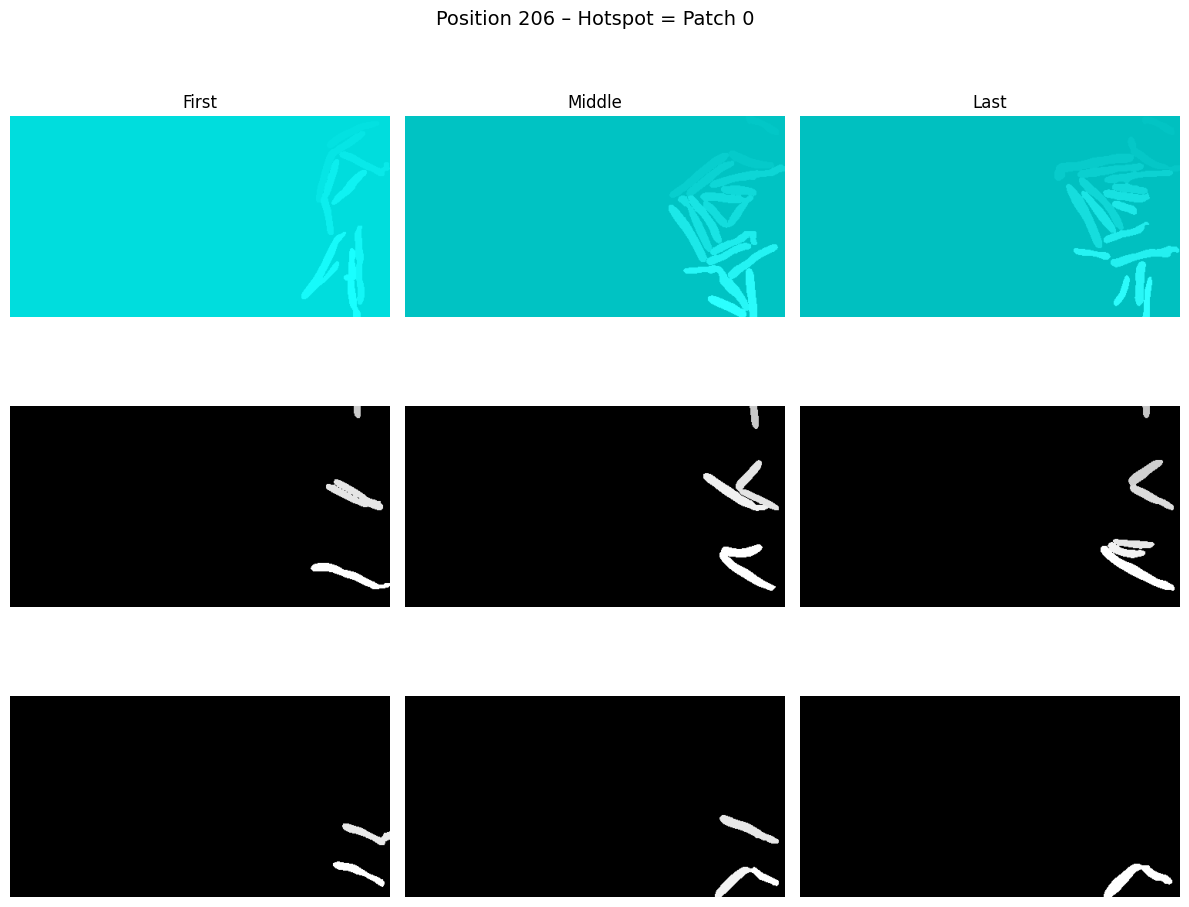

Showing hotspot for position 207


Loading Pos207: 100%|██████████| 121/121 [00:01<00:00, 113.21it/s]


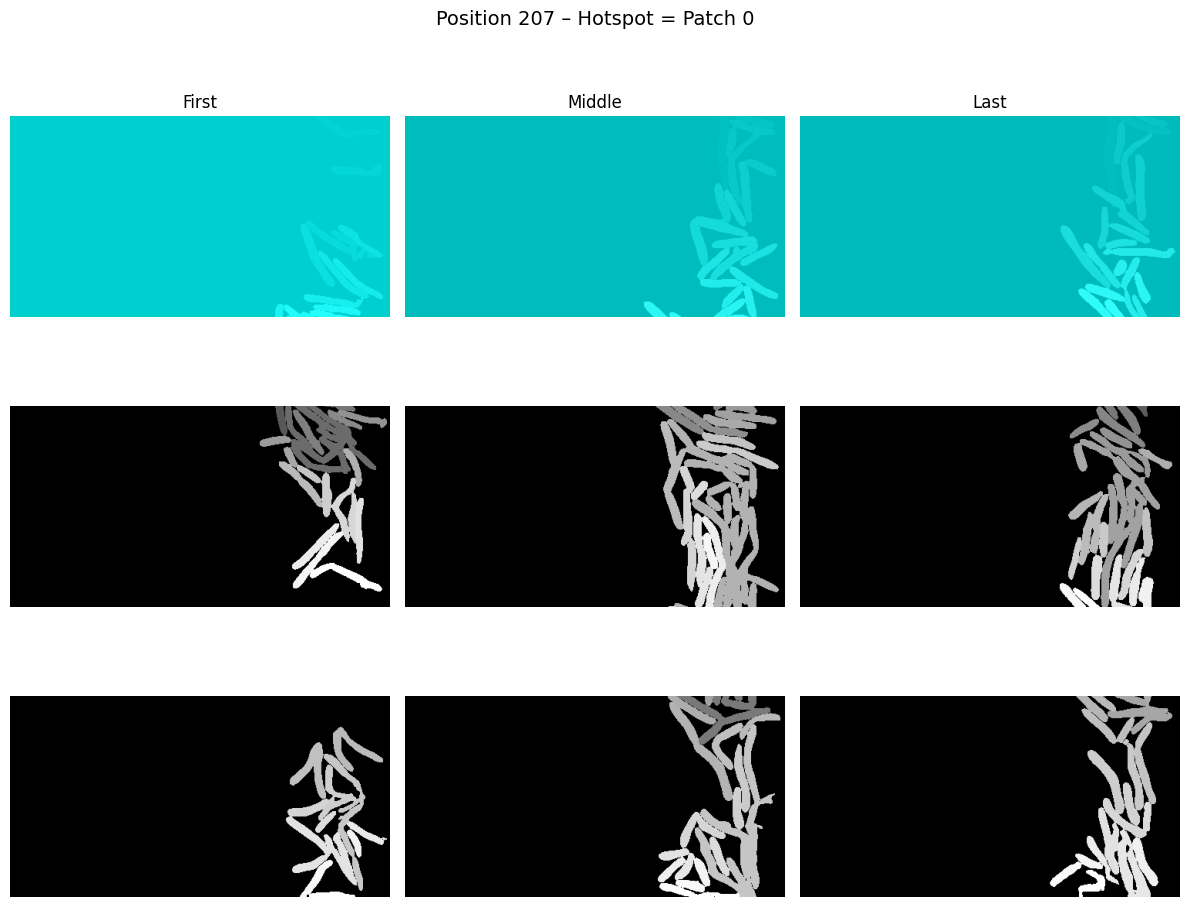

Showing hotspot for position 208


Loading Pos208: 100%|██████████| 121/121 [00:01<00:00, 112.34it/s]


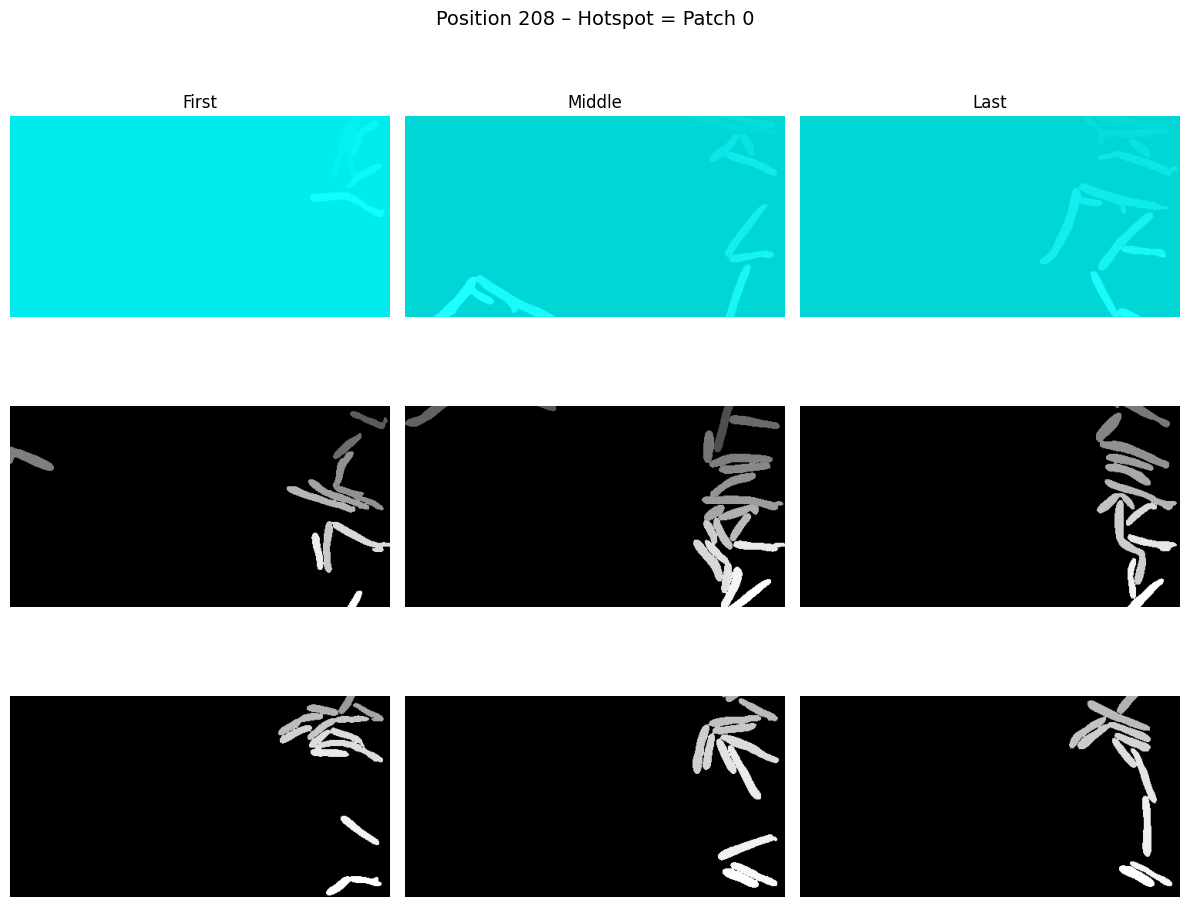

Showing hotspot for position 209


Loading Pos209: 100%|██████████| 121/121 [00:01<00:00, 113.49it/s]


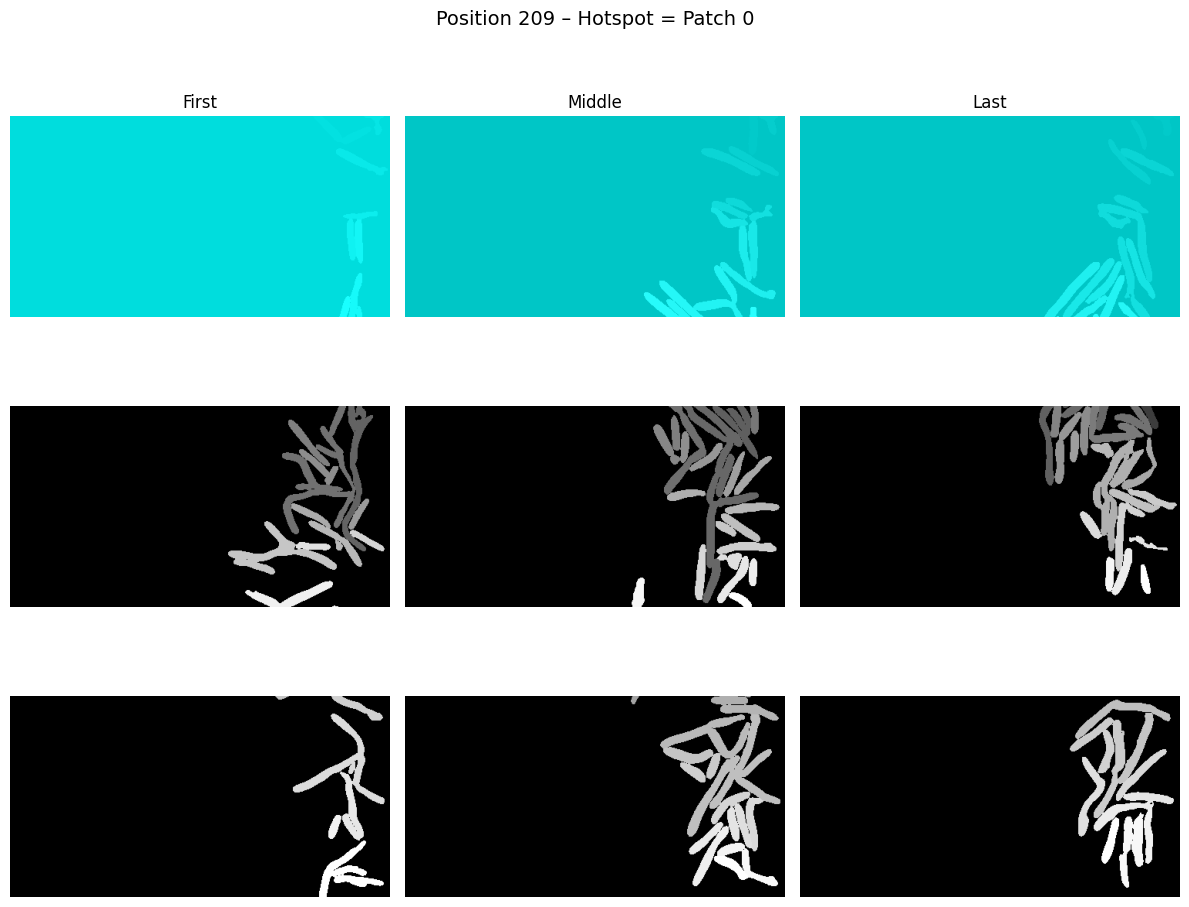

Showing hotspot for position 210


Loading Pos210: 100%|██████████| 121/121 [00:01<00:00, 105.32it/s]


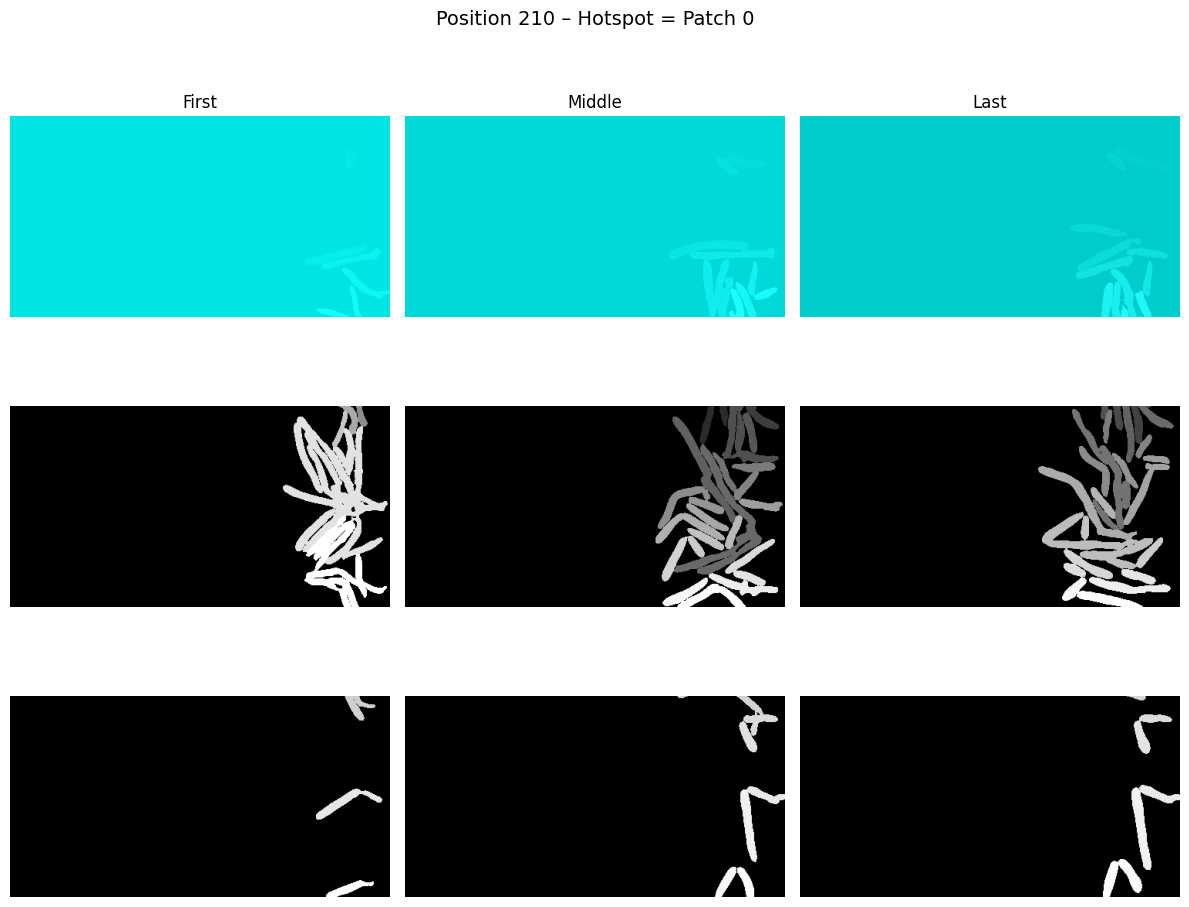

In [82]:
treat_positions = list(range(201, 211))

treat_hotspot_indices = {
    201: 2, 202: 0, 203: 1, 204: 2, 205: 0,
    206: 0, 207: 0, 208: 0, 209: 0, 210: 0
}

for pos in treat_positions:
    print(f"Showing hotspot for position {pos}")
    show_patches_with_hotspot(treat_dir, pos, treat_hotspot_indices[pos], n_patches=3)
